## Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import bp as dfb
import time
from numba import jit
import timeit

## read data

In [2]:
df = pd.read_pickle('Data for Practicum 2/EURUSD/ticks_2019.pkl')

In [3]:
df.columns

Index(['EURUSD.bid', 'EURUSD.ask', 'mid'], dtype='object')

## Data Analysis

In [4]:
time_deltas = df.index.to_series().diff()

In [5]:
def tick_data_describe(df,currency_pair='EURUSD'):
    time_deltas = df.index.to_series().diff()
    price_deltas = df['mid'].diff()
    spread = df[currency_pair+'.ask'] - df[currency_pair+'.bid']
    summary_data = {
        'Description': [
            'Number of ticks',
            'Mean time between ticks',
            'Median time between ticks',
            'Max time between ticks',
            'Min time between ticks',
            'Ticks with time delta > 10 minutes',
            'Ticks with time delta > 60 seconds',
            'Ticks with time delta > 1 second',
            'Ticks with time delta > 0.1 seconds',
            'Ticks with time delta < 0.1 seconds',
            'Mean price delta',
            'Median price delta',
            'Max price delta',
            'Min price delta',
            'instances with price delta < 0.0001',
            'instances with price delta > 0.0001',
            'instances with price delta > 0.001',
            'instances with price delta > 0.01',
            'instances with price delta > 0.1',
            'Mean spread',
            'Median spread',
            'Max spread',
            'Min spread',
            'instances with spread < 0.0001',
            'instances with spread > 0.0001',
            'instances with spread > 0.001',
            'instances with spread > 0.01',
            'instances with spread > 0.1',
        ],
        'Value': [
            len(df),
            time_deltas.mean(),
            time_deltas.median(),
            time_deltas.max(),
            time_deltas.min(),
            len(time_deltas[time_deltas > pd.Timedelta(minutes=10)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=60)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=1)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=0.1)]),
            len(time_deltas[time_deltas < pd.Timedelta(seconds=0.1)]),
            price_deltas.mean(),
            price_deltas.median(),
            price_deltas.max(),
            price_deltas.min(),
            price_deltas[price_deltas < 0.0001].count(),
            price_deltas[price_deltas > 0.0001].count(),
            price_deltas[price_deltas > 0.001].count(),
            price_deltas[price_deltas > 0.01].count(),
            price_deltas[price_deltas > 0.1].count(),
            spread.mean(),
            spread.median(),
            spread.max(),
            spread.min(),
            spread[spread < 0.0001].count(),
            spread[spread > 0.0001].count(),
            spread[spread > 0.001].count(),
            spread[spread > 0.01].count(),
            spread[spread > 0.1].count(),
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    fig, ax = plt.subplots(figsize=(10, 3))  # set the size
    ax.axis('off')
    ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc = 'center',loc='center')
    plt.show()


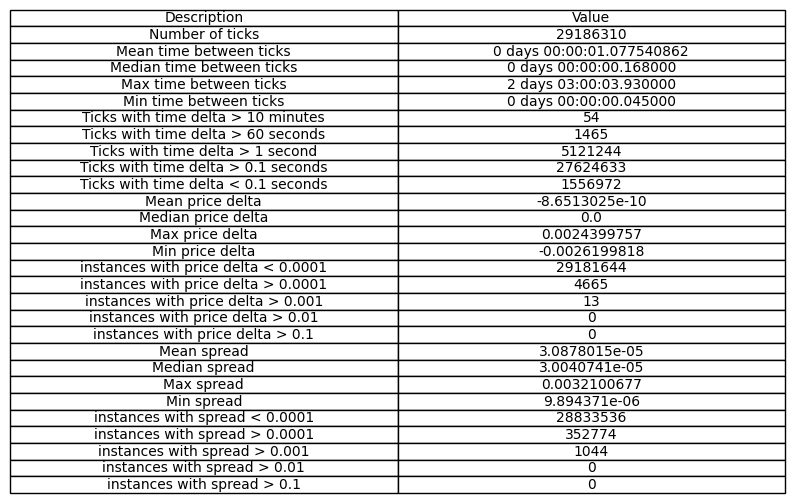

In [6]:
tick_data_describe(df)

In [7]:
ohlc = dfb.tick_to_ohlc(df, '1D')

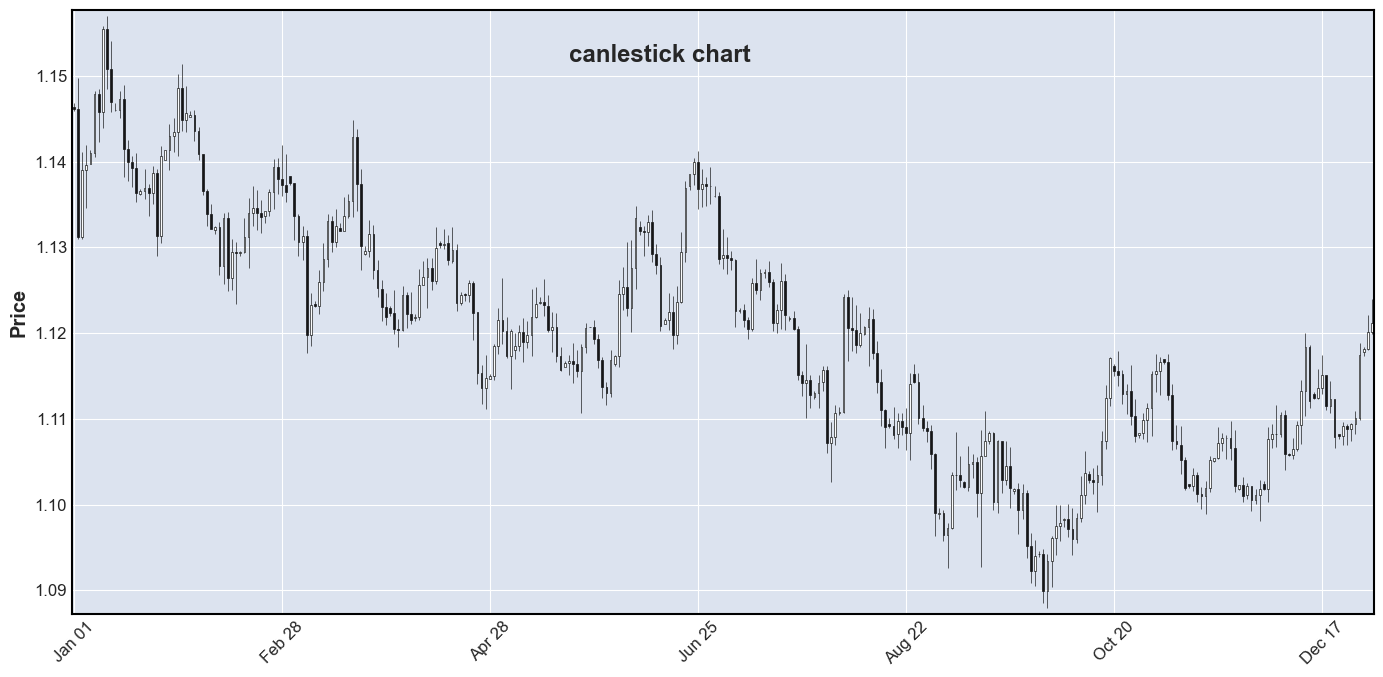

In [8]:
dfb.plot_data(ohlc)

In [9]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    fig,axs = plt.subplots(3,1,figsize=(10,10))
    axs[0].plot(ohlc['returns'])
    axs[1].hist(ohlc['returns'],bins=20)

    daily_volatility = ohlc['returns'].std()*np.sqrt(252)*100
    buy_and_hold_return = ((ohlc['returns']+1).prod() - 1)*100  # Adjusting to get the total return
    mean_return = ohlc['returns'].mean()*100

    stats_data = {
        'Description': [
            'Daily Volatility',
            'Buy and Hold Return',
            'Mean Return'
        ],
        'Value': [
            daily_volatility,
            buy_and_hold_return,
            mean_return
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    axs[2].axis('off')
    axs[2].table(cellText=stats_df.values, colLabels=stats_df.columns, cellLoc = 'center',loc='center')
    fig.tight_layout()
    plt.show()


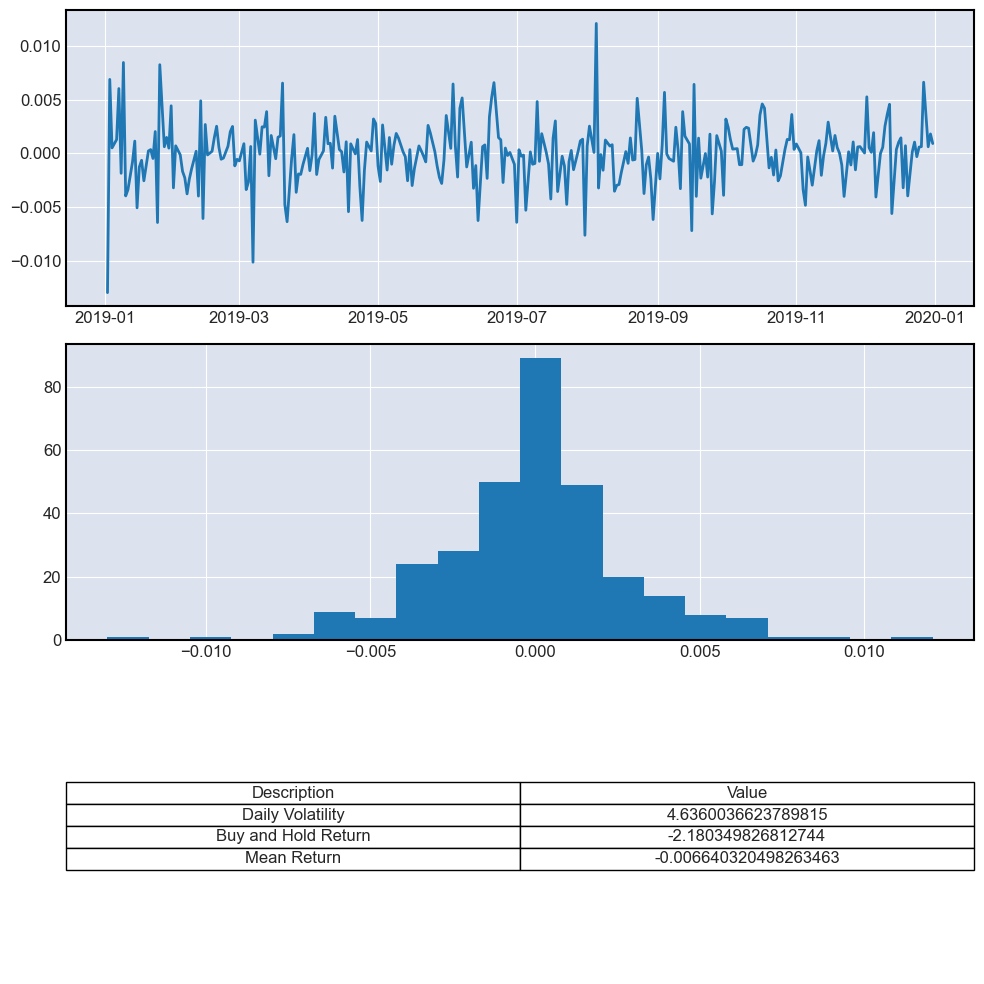

In [10]:
ohlc_stats(ohlc)

In [11]:
def data_analysis_for_bp(tick_data_file,currency_pair='EURUSD'):
    df = pd.read_pickle(tick_data_file)
    tick_data_describe(df,currency_pair)
    ohlc = dfb.tick_to_ohlc(df, '1D')
    dfb.plot_data(ohlc)
    ohlc_stats(ohlc)

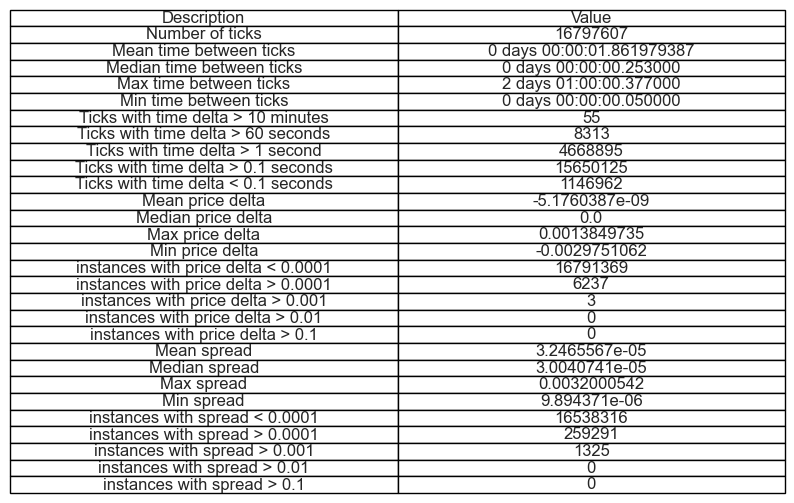

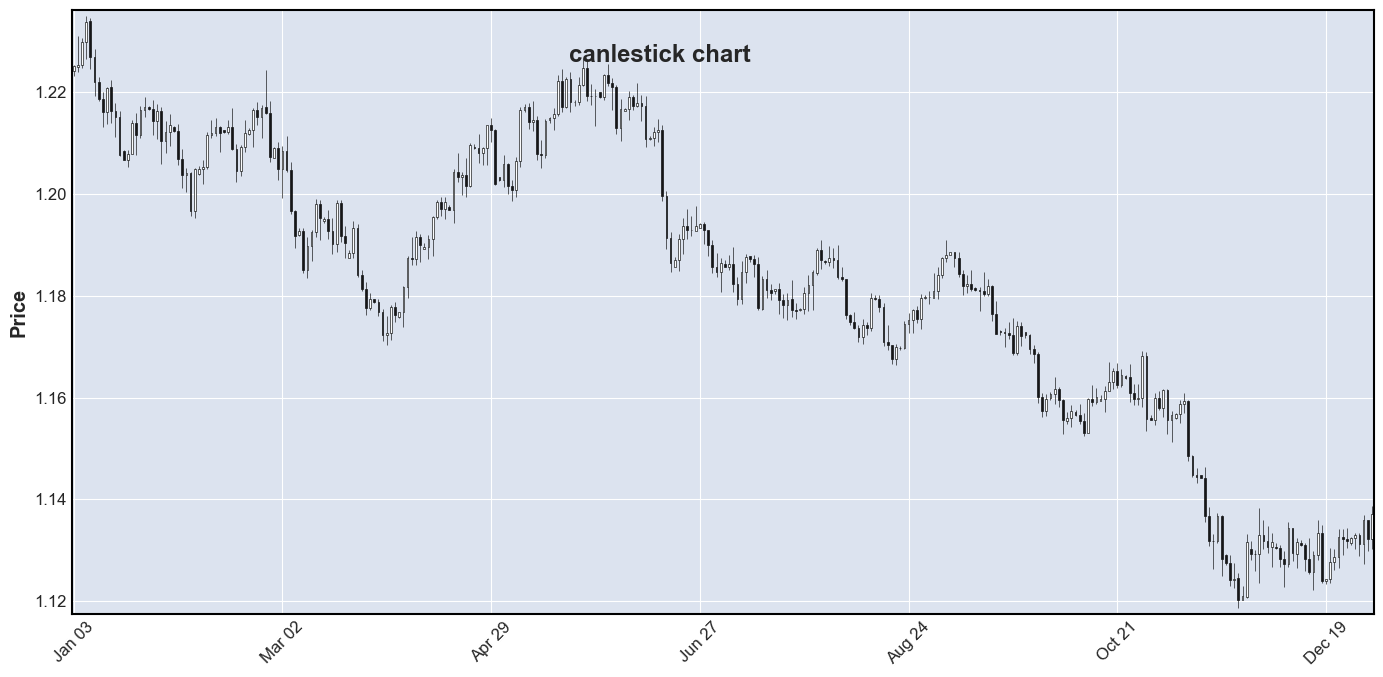

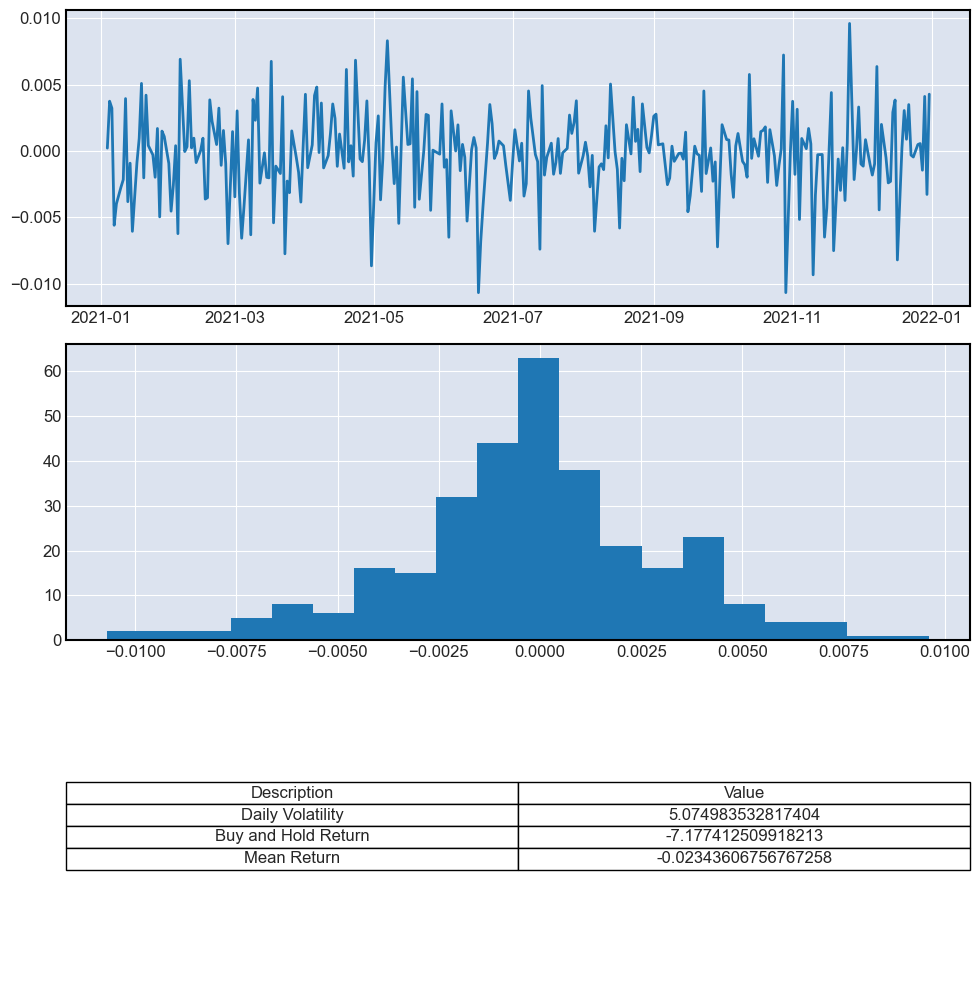

In [12]:
data_analysis_for_bp('Data for Practicum 2/EURUSD/ticks_2021.pkl')

### Optimised Data Gathering

In [13]:
# function that takes in a adate range and if across multiple years splits into year pairs.
def year_order(start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    if start_date.year == end_date.year:
        return {start_date.year: [start_date, end_date]}
    else:
        year_dict = {}
        for year in range(start_date.year, end_date.year + 1):
            if year == start_date.year:
                year_dict[year] = [start_date, pd.to_datetime(str(year+1) + '-12-31')]
            elif year == end_date.year:
                year_dict[year] = [pd.to_datetime(str(year) + '-01-01'), end_date]
            else:
                year_dict[year] = [pd.to_datetime(str(year) + '-01-01'), pd.to_datetime(str(year) + '-12-31')]
        return year_dict

In [14]:
# extracts data from various files based on date range given and then returns it as a single dataframe
def data_gather_from_files(start_date,end_date,file_path='Data for Practicum 2',currency_pair='EURUSD'):
    year_dict = year_order(start_date,end_date)
    full_df = pd.DataFrame()
    for year in year_dict.keys():
        year_df = pd.read_pickle(f'{file_path}/{currency_pair}/ticks_' + str(year) + '.pkl')
        year_dict[year][0] = year_dict[year][0].tz_localize('UTC')
        year_dict[year][1] = year_dict[year][1].tz_localize('UTC')
        year_df = year_df.loc[year_dict[year][0]:year_dict[year][1]]
        full_df = pd.concat([full_df,year_df])
    return full_df

In [15]:
data = data_gather_from_files('27 dec 2019','3 jan 2020',currency_pair='EURUSD')

In [16]:
data

,EURUSD.bid,EURUSD.ask,mid
Date,,,
2019-12-27 00:00:00.443000+00:00,1.11013,1.11015,1.110140
2019-12-27 00:00:00.940000+00:00,1.11011,1.11015,1.110130
2019-12-27 00:00:02.074000+00:00,1.11011,1.11013,1.110120
2019-12-27 00:00:02.175000+00:00,1.11011,1.11014,1.110125
2019-12-27 00:00:02.378000+00:00,1.11011,1.11016,1.110135
...,...,...,...
2020-01-02 23:59:37.622000+00:00,1.11708,1.11711,1.117095
2020-01-02 23:59:39.622000+00:00,1.11708,1.11712,1.117100
2020-01-02 23:59:39.723000+00:00,1.11708,1.11711,1.117095


## Ladder strategy data engineering and strategy visualisation

### Ladderize the data

In [17]:
def ladderize_open(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    ladderized_data = [tick_data.iloc[0]]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [18]:
def ladderize_absolute(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    # Initialize ladder at the nearest rounded price level based on grid size
    ladderized_data = [(tick_data.iloc[0] / grid_size).round() * grid_size]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price and changing th open price
    ladderized_data[-1]=tick_data.iloc[-1]
    ladderized_data[0]=tick_data.iloc[0]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [19]:
def plot_colored_ladder(ladderized_data):
    for i in range(1, len(ladderized_data)):
        if ladderized_data[i] > ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='red')
        elif ladderized_data[i] < ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='green')
        else:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='blue')  # Neutral color for no change

In [22]:

def plot_ladderized(start_date, end_date, grid_size=0.0005, ladderize_function=ladderize_open):
    # Load the tick data
    tick_data = data_gather_from_files(start_date, end_date)['mid']

    ladderized_data = ladderize_function(tick_data, grid_size)

    # Plot the results
    plt.figure(figsize=(15,6))
    plt.plot(tick_data, label='Tick Data',alpha=0.5)
    plot_colored_ladder(ladderized_data)
    # plt.plot(ladderized_data, label='Ladderized Data', linestyle='--')
    plt.title('Ladder Strategy Visualization for date range: {} to {}'.format(start_date, end_date))
    plt.legend()
    plt.show()



KeyboardInterrupt: 

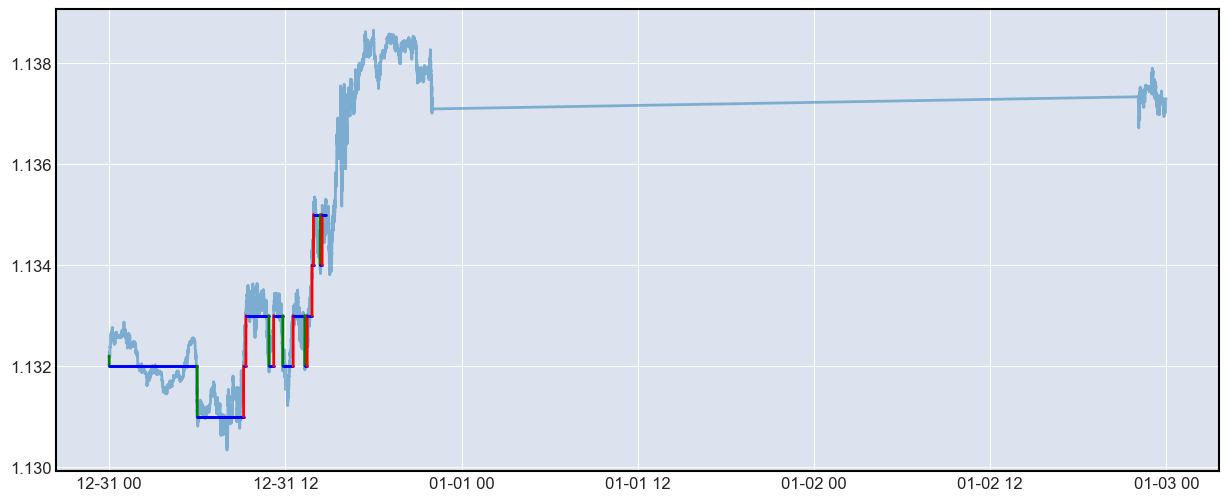

In [23]:
plot_ladderized('31 Dec 2021','3 Jan 2022',grid_size=0.001,ladderize_function=ladderize_absolute)

In [24]:
tick_data = data_gather_from_files('1 Jan 2021','31 Jul 2022')['mid']

In [25]:
for g in [0.001,0.005,0.01]:
    time1 = time.time()
    ladderized_data = ladderize_absolute(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_absolute for g = ',g,': ',time2-time1)

    time1 = time.time()
    ladderized_data = ladderize_open(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_open for g = ',g,': ',time2-time1)

KeyboardInterrupt: 

In [26]:
@jit(nopython=True)
def ladderize_open_loop(n, tick_data, ladderized_data, grid_size):
    ladderized_data[0] = tick_data[0]
    for i in range(1, n):
        last_ladder = ladderized_data[i - 1]
        tick = tick_data[i]
        
        if tick > last_ladder + grid_size:
            ladderized_data[i] = last_ladder + grid_size
        elif tick < last_ladder - grid_size:
            ladderized_data[i] = last_ladder - grid_size
        else:
            ladderized_data[i] = last_ladder

def ladderize_open_optimised(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    n = len(tick_data)
    ladderized_data = np.empty(n, dtype=np.float64)
    tick_data_np = tick_data.values.astype(np.float64)

    ladderize_open_loop(n, tick_data_np, ladderized_data, grid_size)

    # Overwrite the last tick to the exact closing price
    ladderized_data[-1] = tick_data.iloc[-1]
    
    return pd.Series(np.round(ladderized_data, 4), index=tick_data.index)

In [27]:
@jit(nopython=True)
def ladderize_absolute_loop(n, tick_data, ladderized_data, grid_size, rounded_open):
    last_ladder = rounded_open
    for i in range(1,n):
        tick = tick_data[i]
        if tick > last_ladder + grid_size:
            last_ladder += grid_size
        elif tick < last_ladder - grid_size:
            last_ladder -= grid_size
        ladderized_data[i] = last_ladder

def ladderize_absolute_optimised(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    n = len(tick_data)
    ladderized_data = np.empty(n, dtype=np.float64)
    
    # Initialize the first point to the actual opening price
    ladderized_data[0] = tick_data.iloc[0]
    
    # Round the opening price for grid calculations
    rounded_open = (tick_data.iloc[0] / grid_size).round() * grid_size
    
    tick_data_np = tick_data.values.astype(np.float64)
    
    ladderize_absolute_loop(n, tick_data_np, ladderized_data, grid_size, rounded_open)

    # Overwrite the last tick to the exact closing price
    ladderized_data[-1] = tick_data.iloc[-1]
    
    return pd.Series(np.round(ladderized_data, 4), index=tick_data.index)


In [28]:
for g in [0.001,0.005,0.01]:
    time1 = time.time()
    ladderized_data = ladderize_open_optimised(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_absolute for g = ',g,': ',time2-time1)
for g in [0.001,0.005,0.01]:
    time1 = time.time()
    ladderized_data = ladderize_absolute_optimised(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_open for g = ',g,': ',time2-time1)

ladderize_absolute for g =  0.001 :  0.3640251159667969
ladderize_absolute for g =  0.005 :  0.12718605995178223
ladderize_absolute for g =  0.01 :  0.05366086959838867
ladderize_open for g =  0.001 :  0.11376118659973145
ladderize_open for g =  0.005 :  0.05116009712219238
ladderize_open for g =  0.01 :  0.0507960319519043


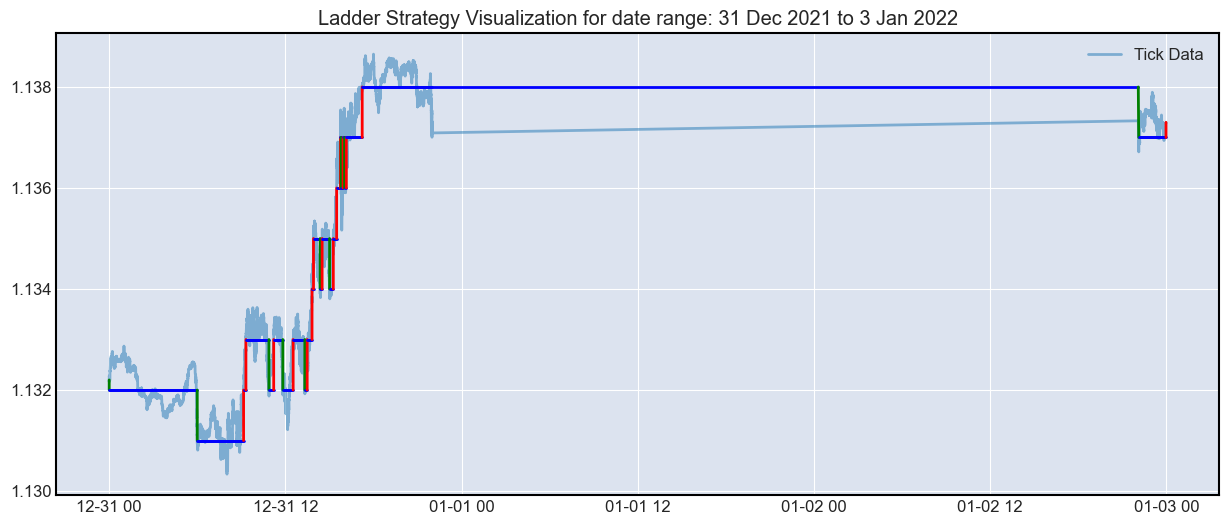

In [29]:
plot_ladderized('31 Dec 2021','3 Jan 2022',grid_size=0.001,ladderize_function=ladderize_absolute_optimised)

### filter jumps and plot 

In [30]:
def filter_jumps(ladderized_data):
    """
    Filters ladderized data to keep only the changes in price.

    :param ladderized_data: A pandas Series of ladderized data.
    :return: A pandas Series containing only the data points where there's a change.
    """
    # Calculate the difference between consecutive ladderized data points
    diff = ladderized_data.diff()
    # Filter where the difference is non-zero and include the first data point
    jumps = ladderized_data[diff != 0.0]
    return jumps


In [31]:
def aggregate_differences(jumps,lot_size=1):
    """
    Aggregate the position for buy/sell signals.

    :param jumps: A pandas Series of ladderized data filtered for jumps.
    :return: A pandas Series representing the aggregated position.
    """
    aggregated_position = [0]  # starting from 0
    position = 0
    previous_value = jumps.values[0]
    
    for value in jumps.values[1:]:
        if value > previous_value:
            position -= lot_size  # selling one lot
        else:
            position += lot_size  # buying one lot
        aggregated_position.append(position)
        previous_value = value
    aggregated_position[-1]=0 # closing the position
    return pd.Series(aggregated_position, index=jumps.index)


In [32]:
def plot_jumps(ladderized_data):
    jumps = filter_jumps(ladderized_data)
    aggregated_diff = aggregate_differences(jumps)
    fig,axs = plt.subplots(2,1,figsize=(10,10))
    # Plotting the jumps
    axs[0].plot(jumps.values, label='binomial jumps', linestyle='--', alpha=0.7)
    axs[0].set_title('ladder with jumps')
    # Adding colored points for up and down movements
    previous_value = jumps.values[0]
    for idx, value in enumerate(jumps.values[1:], 1):
        if idx == len(jumps)-1:
            continue
        elif value > previous_value:
            axs[0].plot(idx, value, 'ro')  # Red point for upward movement
        elif value < previous_value:
            axs[0].plot(idx, value, 'go')  # green point for downward movement
        else:
            axs[0].plot(idx, value, 'bo') # blue point for no change
        previous_value = value
        
        # Add vertical line to all subplots
        for ax in axs:
            ax.axvline(idx, alpha=0.5, color='gray')
            
            
    axs[0].legend()
    # Plotting the aggregated differences
    axs[1].plot(aggregated_diff.values, label='position', linestyle='-', color='purple', alpha=0.8, drawstyle='steps-post')
    axs[1].legend()
    axs[1].set_title('positions')
    plt.show()

In [45]:
tick_data = data_gather_from_files('1 Jan 2021','31 jan 2022')['mid']
ladderized_data = ladderize_absolute_optimised(tick_data, grid_size=0.01)

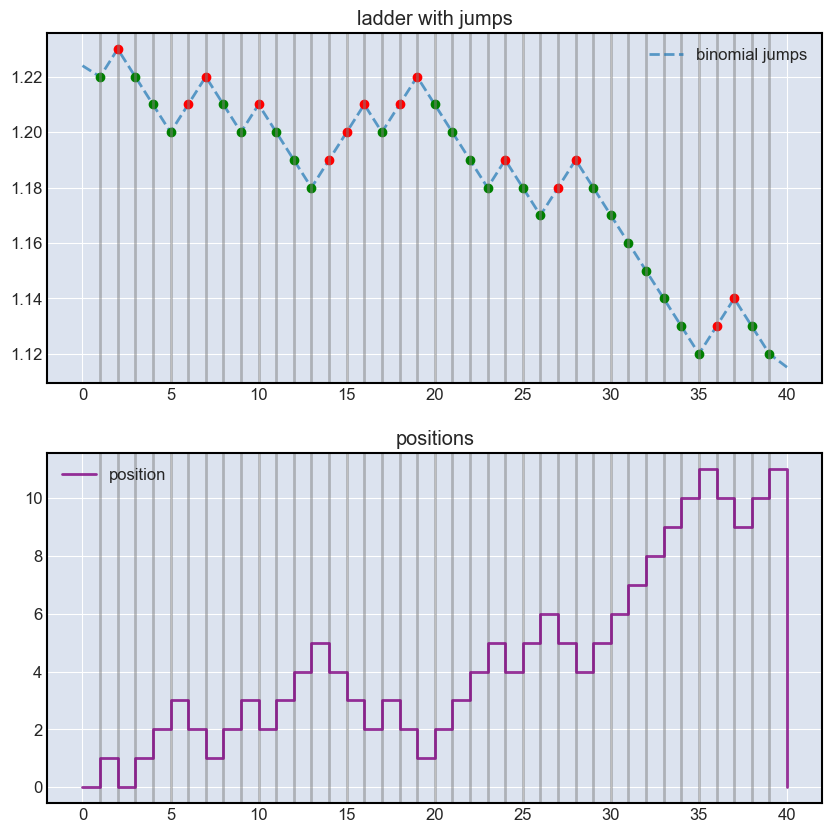

In [47]:
plot_jumps(ladderized_data)

### indicators for lot sizing

In [48]:
def velocity(data,grid_sizing,indicator_scale=5):
    return np.round(indicator_scale*data.diff()/(data)/grid_sizing,1)

def acceleration(data,grid_sizing,indicator_scale=5):
    return np.round(indicator_scale*data.diff().diff()/(data)/grid_sizing,1)

def direction(data):
    return np.sign(data.diff())

In [49]:
jumps = filter_jumps(ladderized_data)
jump_ema = jumps.ewm(span=10).mean()

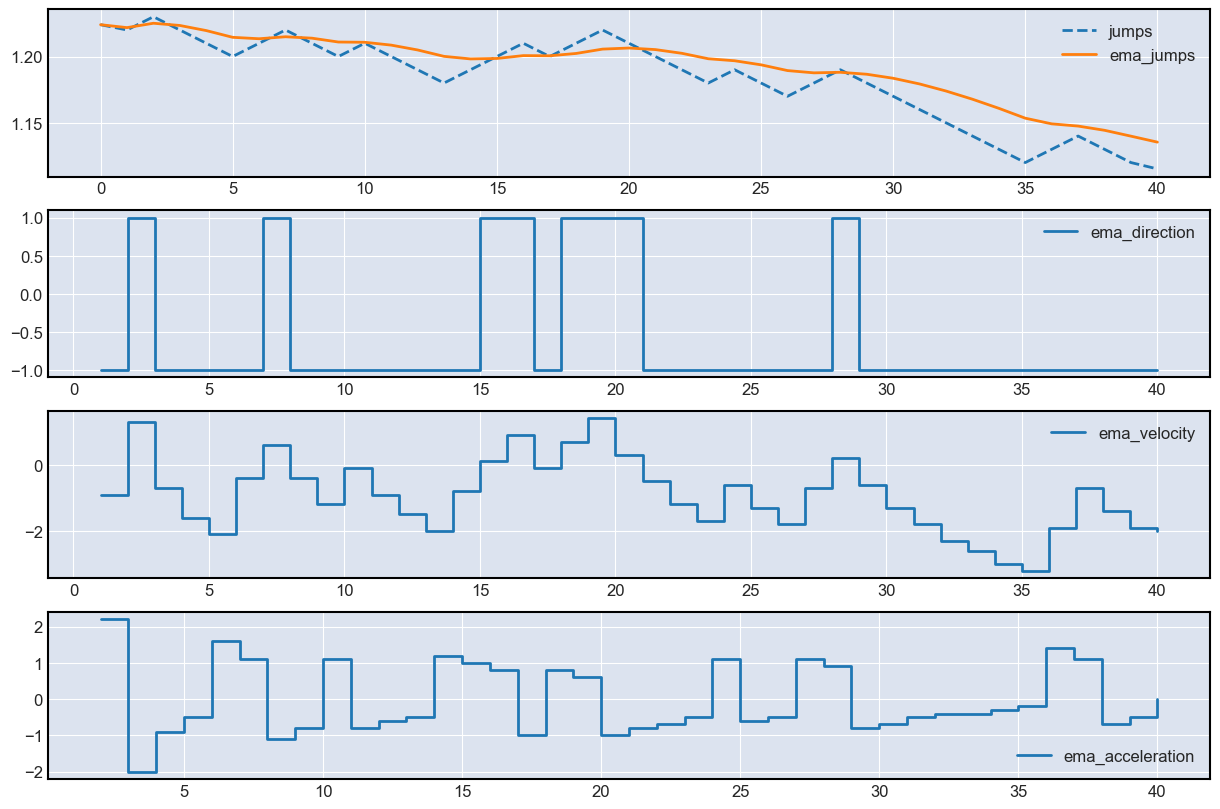

In [50]:
# Plot the results
def plot_indicator_graph(jumps,grid_size,lookback=10,scale=5):
    jump_ema = jumps.ewm(span=lookback).mean()
    fig,axs = plt.subplots(4,1,figsize=(15,10))
    axs[0].plot(jumps.values, label='jumps', linestyle='--')
    axs[0].plot(jump_ema.values, label='ema_jumps', linestyle='-')
    #axs[0].plot(ladderized_data, label='Ladderized Data',alpha=0.5)
    axs[0].legend()
    axs[1].plot(direction(jump_ema).values, label='ema_direction',drawstyle='steps-post')
    axs[1].legend()
    axs[2].plot(velocity(jump_ema,grid_size,scale).values, label='ema_velocity',drawstyle='steps-post')
    axs[2].legend()
    axs[3].plot(acceleration(jump_ema,grid_size,scale).values, label='ema_acceleration',drawstyle='steps-post')
    axs[3].legend()
    plt.show()
plot_indicator_graph(jumps,0.01,lookback=10)

In [51]:
def indicator_prep(data,grid_sizing,lookback = 200,Type = 'd',indicator_scale=5):
    if Type == 'a':
        data = acceleration(data.ewm(span=lookback).mean(),grid_sizing,indicator_scale).shift(1)
    elif Type == 'v':
        data = velocity(data.ewm(span=lookback).mean(),grid_sizing,indicator_scale).shift(1) # we shift this because our lot sizing will be decided by what the values are prior not current
    else:
        data = direction(data.ewm(span=lookback).mean()).shift(1)
    data[np.isnan(data)] = 0
    return data

### conversion to binomial

In [52]:
def convert_to_grid_binomial_data(tick_data,grid_size,ladderized_function):
    """
    Convert tick data to a binomial grid representation using a ladderized function.

    Parameters:
    - tick_data (pd.Series or np.array): The raw tick data to be processed.
    - grid_size (float): The size of the grid to which the tick data will be mapped.
    - ladderized_function (callable): A function that ladderizes the tick data based on the grid size.
    - ladder_depth (int, optional): The maximum depth of the ladder. Default is 10.

    Returns:
    - tuple:
        - jumps (pd.Series or np.array): The ladderized tick data after filtering jumps.
        - binomial_data (pd.Series or np.array): The binomial representation of the tick data, where 1 indicates an upward move, -1 indicates a downward move, and 0 indicates no move beyond the ladder depth.

    Notes:
    The function first ladderizes the tick data using the provided ladderized function. It then identifies and filters out jumps in the ladderized data. The differences between consecutive ladderized data points are computed to generate the binomial representation. The binomial data is then adjusted such that any cumulative sum (or ladder aggregate) beyond the specified ladder depth is set to 0.

    Example:
    Given tick_data as [100, 101, 102, 104], grid_size as 1, and ladderized_function that rounds to the nearest integer:
    The ladderized data might be [100, 101, 102, 104]
    The jumps, after filtering, might remain the same.
    The binomial data would be [0, 1, 1, 1]
    """
    ladderized_data = ladderized_function(tick_data,grid_size)
    jumps = filter_jumps(ladderized_data)
    binomial_data = jumps.diff()
    binomial_data[1:] = np.where(binomial_data[1:] > 0,1,-1) # 1 for up and -1 for down
    binomial_data[0] = 0 # first value is always 0
    return jumps,binomial_data

In [53]:
def timed_convert_to_grid_binomial_data(tick_data,grid_size,ladderized_function):
    """
    Convert tick data to a binomial grid representation using a ladderized function.

    Parameters:
    - tick_data (pd.Series or np.array): The raw tick data to be processed.
    - grid_size (float): The size of the grid to which the tick data will be mapped.
    - ladderized_function (callable): A function that ladderizes the tick data based on the grid size.
    - ladder_depth (int, optional): The maximum depth of the ladder. Default is 10.

    Returns:
    - tuple:
        - jumps (pd.Series or np.array): The ladderized tick data after filtering jumps.
        - binomial_data (pd.Series or np.array): The binomial representation of the tick data, where 1 indicates an upward move, -1 indicates a downward move, and 0 indicates no move beyond the ladder depth.

    Notes:
    The function first ladderizes the tick data using the provided ladderized function. It then identifies and filters out jumps in the ladderized data. The differences between consecutive ladderized data points are computed to generate the binomial representation. The binomial data is then adjusted such that any cumulative sum (or ladder aggregate) beyond the specified ladder depth is set to 0.

    Example:
    Given tick_data as [100, 101, 102, 104], grid_size as 1, and ladderized_function that rounds to the nearest integer:
    The ladderized data might be [100, 101, 102, 104]
    The jumps, after filtering, might remain the same.
    The binomial data would be [0, 1, 1, 1]
    """
    time1 = time.time()
    ladderized_data = ladderized_function(tick_data,grid_size)
    time2 = time.time()
    jumps = filter_jumps(ladderized_data)
    time3 = time.time()
    binomial_data = jumps.diff()
    binomial_data[1:] = np.where(binomial_data[1:] > 0,1,-1) # 1 for up and -1 for down
    binomial_data[0] = 0 # first value is always 0
    time4 = time.time()
    print('ladderize time: ',time2-time1)
    print('filter jumps time: ',time3-time2)
    print('binomial data time: ',time4-time3)
    return jumps,binomial_data

In [54]:
grid_jumps,binomial_data = timed_convert_to_grid_binomial_data(tick_data,0.001,ladderize_open_optimised)

ladderize time:  0.030248165130615234
filter jumps time:  0.016876935958862305
binomial data time:  0.0005080699920654297


In [55]:
np.min(np.cumsum(binomial_data))

-111.0

In [56]:
np.cumsum(binomial_data)

Date
2021-01-03 22:00:00.040000+00:00      0.0
2021-01-03 23:49:17.162000+00:00      1.0
2021-01-04 00:36:59.567000+00:00      0.0
2021-01-04 01:10:56.733000+00:00      1.0
2021-01-04 07:08:32.306000+00:00      2.0
                                    ...  
2022-01-28 15:50:02.495000+00:00   -108.0
2022-01-28 18:22:16.036000+00:00   -109.0
2022-01-30 23:02:20.873000+00:00   -110.0
2022-01-30 23:58:33.265000+00:00   -109.0
2022-01-30 23:59:57.947000+00:00   -108.0
Length: 4327, dtype: float64

## Strategy

### load the data

In [58]:
start_date = '1 Jan 2021'
end_date = '31 Mar 2021'
tick_data = data_gather_from_files(start_date,end_date)['mid']

In [59]:
grid_sizing = 0.003
lot_sizing = 500000
grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladderize_absolute_optimised)

In [60]:
max(np.max(np.cumsum(binomial_data)),np.abs(np.min(np.cumsum(binomial_data))))

18.0

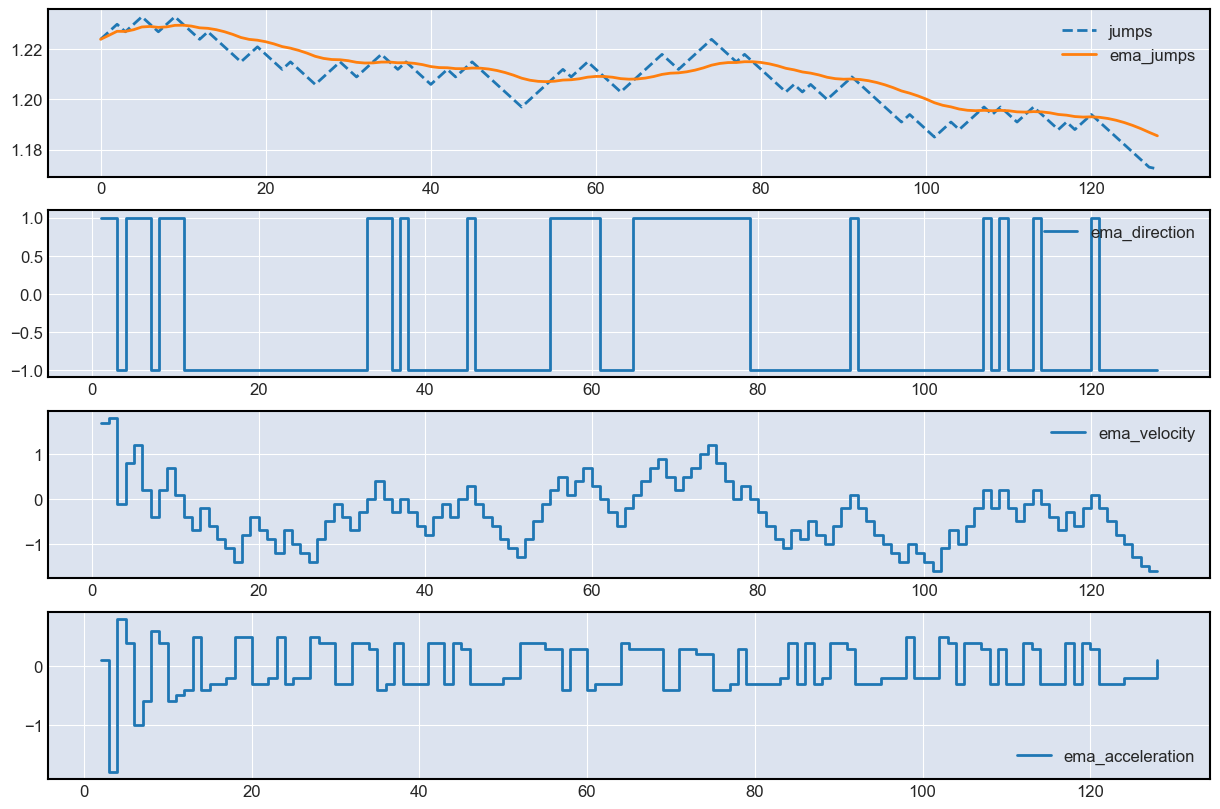

In [61]:
plot_indicator_graph(grid_jumps,grid_sizing,lookback=20,scale=4)

### function that helps scale and build lot sizing based on indicators and trade_depth

In [ ]:
def build_lot_sizing(lot_sizing,binomial_data,multiplier=1,indicator_data=[],just_direction=True,min_lot_size = 10000,scale_both = False):
    """
    Compute the lot sizing for trading based on binomial data and optional indicator data.

    Parameters:
    - lot_sizing (float): Base lot size for trading.
    - binomial_data (pd.Series or np.array): Binomial representation of tick data, where 1 indicates an upward move, -1 indicates a downward move.
    - multiplier (float, optional): Multiplier for scaling the lot size. Default is 1.
    - indicator_data (list or np.array, optional): Additional data used for scaling the lot size based on the direction of the binomial data. Default is an empty list.

    Returns:
    - np.array: Array of lot sizes for each time step.

    Notes:
    If no indicator data is provided, the function returns a list of lot sizes scaled by the multiplier for each time step.
    If indicator data is provided, the function scales the lot size based on the alignment of the binomial data and the indicator data. Specifically, if both the binomial data and the indicator data have the same sign (indicating movement in the same direction), the lot size is inversely scaled. Otherwise, it is scaled up.

    """
    T = len(binomial_data)
    if len(indicator_data) == 0:
        return np.ones(T)*lot_sizing
    if just_direction: # Only directional data is present
        positions = np.ones(T)*lot_sizing
        for i in range(1,len(binomial_data)):
            if indicator_data[i]*binomial_data[i]<0: # checks if market direction and binomial step are opposite
                if positions[i-1] < lot_sizing:
                    positions[i] = lot_sizing
                else:
                    positions[i] = positions[i-1]*multiplier
            else:
                if scale_both and positions[i-1] > lot_sizing:
                    positions[i] = lot_sizing
                elif scale_both:
                    positions[i] = positions[i-1]/multiplier
                else:
                    positions[i] = lot_sizing
        return positions
    else: # other indicators are present
        scaling_criteria =  binomial_data * indicator_data  # +ve if both are same sign hence signifies movement in same direction , we do not scale in that case
        #positions = np.where(scaling_criteria > 0,1/(1+abs(scaling_criteria)),1+abs(scaling_criteria))*lot_sizing # +ve if both are same sign hence signifies movement in same direction, we scale in by inverse
        if scale_both:
            positions = np.where(scaling_criteria > 0,1/(1+abs(scaling_criteria)),1+abs(scaling_criteria))*lot_sizing
        else:
            positions = np.where(scaling_criteria > 0,1,1+abs(scaling_criteria))*lot_sizing
        positions[np.isnan(positions)] = 0
        return np.round(positions/min_lot_size,0)*min_lot_size

### Prepares the indicator data for the scaling the lot sizing

In [ ]:
indicator_data = indicator_prep(grid_jumps,grid_sizing,Type='v',lookback=200)

In [ ]:
position_data = build_lot_sizing(lot_sizing,binomial_data,multiplier=2,indicator_data=indicator_data,just_direction=True,scale_both = True)

In [ ]:
for i in range(len(position_data)):
    print(position_data[i],indicator_data[i],binomial_data[i])

500000.0 0.0 0.0
250000.0 0.0 1.0
125000.0 2.1 1.0
500000.0 2.1 -1.0
250000.0 -0.0 1.0
125000.0 0.8 1.0
500000.0 1.2 -1.0
1000000.0 0.3 -1.0
2000000.0 -0.3 1.0
500000.0 0.2 1.0
1000000.0 0.6 -1.0
2000000.0 0.1 -1.0
500000.0 -0.3 -1.0
1000000.0 -0.6 1.0
500000.0 -0.2 -1.0
250000.0 -0.4 -1.0
125000.0 -0.7 -1.0
62500.0 -0.8 -1.0
500000.0 -1.0 1.0
1000000.0 -0.7 1.0
500000.0 -0.4 -1.0
250000.0 -0.5 -1.0
125000.0 -0.7 -1.0
500000.0 -0.8 1.0
250000.0 -0.6 -1.0
125000.0 -0.7 -1.0
62500.0 -0.8 -1.0
500000.0 -0.9 1.0
1000000.0 -0.7 1.0
2000000.0 -0.5 1.0
500000.0 -0.3 -1.0
250000.0 -0.4 -1.0
500000.0 -0.6 1.0
1000000.0 -0.4 1.0
2000000.0 -0.2 1.0
500000.0 -0.1 -1.0
250000.0 -0.2 -1.0
500000.0 -0.3 1.0
250000.0 -0.2 -1.0
125000.0 -0.3 -1.0
62500.0 -0.4 -1.0
500000.0 -0.5 1.0
1000000.0 -0.4 1.0
500000.0 -0.2 -1.0
1000000.0 -0.3 1.0
2000000.0 -0.2 1.0
500000.0 -0.1 -1.0
250000.0 -0.2 -1.0
125000.0 -0.3 -1.0
62500.0 -0.4 -1.0
31250.0 -0.5 -1.0
15625.0 -0.6 -1.0
500000.0 -0.6 1.0
1000000.0 -0.5 1.0


### function to plot trades , positions (in dollar terms) and PNL (realised , unrealised and total)

In [ ]:
def plot_trades(grid_jumps, R_PNL, U_PNL, N, lookback=200):
    """
    Plot trading data including buy/sell points, lot sizes held, and PNL.

    Parameters:
    - grid_jumps (pd.Series): Ladderized tick data after filtering jumps.
    - R_PNL (pd.Series or np.array): Realized Profit and Loss (PNL) over time.
    - U_PNL (pd.Series or np.array): Unrealized Profit and Loss (PNL) over time.
    - N (pd.Series or np.array): Number of lots held over time.
    - lookback (int, optional): Lookback period for the exponential moving average (EMA) indicator. Default is 200.

    Returns:
    - None: Displays a matplotlib plot with three subplots.

    Notes:
    The function generates a plot with three subplots:
    1. Buy/sell points: This subplot displays the grid jumps with an EMA overlay. Buy points are indicated with red dots, sell points with green dots, and no change with blue dots.
    2. Lots held: This subplot displays the number of lots held over time.
    3. PNL: This subplot displays the unrealized PNL, realized PNL, and total PNL over time.

    Each buy/sell/no-change point in the first subplot corresponds to a vertical line across all subplots for visual alignment.

    Example:
    Given grid_jumps as a time series of ladderized tick data, R_PNL and U_PNL as time series of realized and unrealized PNL respectively, and N as a time series of lots held, the function will display the described plots.
    """
    fig,axs = plt.subplots(3,1,figsize=(15,15))
    axs[0].plot(grid_jumps.values, label='jumps', linestyle='--')
    axs[0].plot(grid_jumps.ewm(span=lookback).mean().values, label='indicator', linestyle='-',alpha=0.6)
    for idx, i in enumerate(grid_jumps):
        if grid_jumps[idx] > grid_jumps[idx-1]:
            axs[0].plot(idx, i, 'ro')  # Red point for upward movement
        elif grid_jumps[idx] < grid_jumps[idx-1]:
            axs[0].plot(idx, i, 'go')  # Green point for downward movement
        else:
            axs[0].plot(idx, i, 'bo')  # Blue point for no change

        # Add vertical line to all subplots
        for ax in axs:
            ax.axvline(idx, alpha=0.2, color='gray')

    axs[0].set_title('buy sell points')
    axs[1].plot(N,drawstyle='steps-post')
    # change number of digits in y axis
    axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axs[1].set_title('lots held')
    axs[2].plot(U_PNL,drawstyle='steps-post',label='Unrealised PNL')
    axs[2].plot(R_PNL,drawstyle='steps-post',label='Realised PNL')
    axs[2].plot(U_PNL+R_PNL,drawstyle='steps-post',label='Total PNL')
    axs[2].legend()
    axs[2].set_title('PNL')
    plt.show()


### Function to format the data in our dataframe 

In [ ]:
def format_df(df):
    # Set the display option for floats
    pd.options.display.float_format = '{:,.2f}'.format

    # Format the DataFrame
    formatted_df = df.style.format({
        't': '{:,.0f}',  # Fixed the missing quotation mark here
        'price': '{:,.3f}',
        'Previous_lots': '{:,.0f}',
        'current_lots': '{:,.0f}',  # Fixed the missing quotation mark here
        'position': '{:,.2f}',
        'Unrealised_PNL': '{:,.2f}',
        'Realized_PNL': '{:,.2f}'
    })
    return formatted_df

### Actual strategy function - calculates all the metrics

In [ ]:
def run_strategy_eval(tick_data,grid_sizing,lot_sizing,ladder_function=ladderize_absolute_optimised,multiplier=1,indicator_type='d',indicator_scale=5,lookback = 200,print_trade_book=False,trade_plot=False):
    """
    Evaluate and visualize a trading strategy based on ladderized tick data and optional indicators.

    Parameters:
    - tick_data (pd.Series or np.array): The raw tick data to be processed.
    - grid_sizing (float): The size of the grid to which the tick data will be mapped.
    - lot_sizing (float): Base lot size for trading.
    - ladder_function (callable, optional): A function that ladderizes the tick data based on the grid size. Default is ladderize_absolute.
    - multiplier (float, optional): Multiplier for scaling the lot size. Default is 1.
    - indicator (bool, optional): Flag to determine if an indicator should be used. Default is False.
    - lookback (int, optional): Lookback period for the indicator. Default is 200.
    - print_trade_book (bool, optional): Flag to print trade details for each time step. Default is False.
    - trade_plot (bool, optional): Flag to plot the trading data. Default is False.

    Returns:
    - pd.DataFrame: A dataframe containing trade details for each time step, including price, lots, position, realized and unrealized PNL, and average price.

    Notes:
    The function evaluates a trading strategy based on ladderized tick data and optional indicators. It computes the realized and unrealized PNL, position, and average price for each time step. The function can also print trade details for each time step and plot the trading data.

    The strategy is evaluated by first converting the tick data to a binomial grid representation using the provided ladder function. If an indicator is used, it is prepared based on the grid jumps and grid sizing. The position sizing is then computed based on the binomial data, lot sizing, multiplier, and optional indicator data.

    The function then iterates over each time step, computing the number of lots in order, position, realized and unrealized PNL, and average price. The results are stored in a dataframe, which is returned.

    """
    time1 = time.time()
    grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladder_function)
    time2 = time.time()
    indicator_data = indicator_prep(grid_jumps,grid_sizing,lookback=lookback,Type=indicator_type,indicator_scale=indicator_scale)
    time3 = time.time()

    T = len(binomial_data)
    PNL = np.zeros(T)
    R_PNL = np.zeros(T)
    U_PNL = np.zeros(T)
    P = np.zeros(T)
    N = np.zeros(T)
    trades = pd.DataFrame({})
    
    direction = False
    if indicator_type == 'd':
        direction = True
        
    position_sizing = build_lot_sizing(lot_sizing,binomial_data,multiplier=multiplier,indicator_data=indicator_data,just_direction=direction)
    time4=time.time()
    avg_price = 0
    for t in np.arange(0,T):
        lots_in_order = - position_sizing[t] * binomial_data[t]
        N[t] = N[t-1] + lots_in_order
        P[t] = P[t-1] + lots_in_order * grid_jumps[t] # cash spent
        
        # check if max_position will get breached with the trade- calculated well before the trade is executed
        if (np.abs(P[t]) >= 10e6):
            print('position limit breached at {},'.format(t))
            print('position rest to P[t-1] = {}'.format(P[t-1]))
            lots_in_order = 0
            N[t] = N[t-1]
            P[t] = P[t-1]
        
        # we have 2 different situation to consider:
        # we close existing positions
        if ((N[t-1]<0) and (N[t]>N[t-1])) or ((N[t-1]>0) and (N[t]<N[t-1])): # if we are closing a position in short and long direction
            if N[t-1]*N[t] < 0: # if we are looking at the order being partially filled
                R_PNL[t] = R_PNL[t-1] + (grid_jumps[t] - avg_price) * (N[t-1]) # realised PNL
                # update avg price based on partially opened orders 
                avg_price = grid_jumps[t]
            else:
                R_PNL[t] = R_PNL[t-1] - (grid_jumps[t] - avg_price) * lots_in_order # realised PNL
        # else if we are only adding to our positions 
        else: # if we are opening a position or adding to an existing position
            R_PNL[t] = R_PNL[t-1] # realised PNL remains the same
            # since we are adding to an existing position we need to update the avg price
            if N[t]!=0: # to avoid divide by zero error
                avg_price = (avg_price * N[t-1] + grid_jumps[t]*lots_in_order)/N[t] # update avg price
            # if N[t] == 0 we are closing a position and hence avg price is not updated

        U_PNL[t] = (grid_jumps[t] - avg_price) * N[t] # unrealised PNL
        PNL[t] = PNL[t-1] + N[t-1] * (grid_jumps[t] - grid_jumps[t-1])
        
        # if unrealised PNL is less than -150k we close all positions and reset
        if U_PNL[t] < -150e3:
            print('closing all positions at t = {}'.format(t))
            R_PNL[t] = R_PNL[t] - 150e3
            U_PNL[t] = 0
            PNL[t] = R_PNL[t]
            avg_price = 0
            N[t] = 0
            P[t] = 0

        PNL[t]=np.round(PNL[t],4)
        U_PNL[t]=np.round(U_PNL[t],4)
        R_PNL[t]=np.round(R_PNL[t],4)
        
        
        # checks if profit calculations are right
        error = np.round(PNL[t] - R_PNL[t] - U_PNL[t],2) # total profit must be equal to cumulative sum of realised + unrealised profit
        if (error!=0):
            print('error at t = {}, error = {}'.format(t,error))

        if print_trade_book:
            print('At t = {}'.format(t))
            if t == 0:
                print('no trades')
            elif lots_in_order > 0:
                print('buy {} lots at price {}'.format(lots_in_order,grid_jumps[t]))
            else:
                print('sell {} lots at price {}'.format(-lots_in_order,grid_jumps[t]))
            print('average price = {}'.format(avg_price))
            print('cummulative realised PNL = {}'.format(R_PNL[t]))
            print('unrealised PNL = {}'.format(U_PNL[t]))
            print('PNL = {}'.format(PNL[t]))
        trade = pd.Series({'t':t,'price':grid_jumps[t],'lots_in_order':lots_in_order,'Previous_lots':N[t-1],'current_lots':N[t],'position':P[t],'R_PNL':R_PNL[t],'U_PNL':U_PNL[t],'PNL':PNL[t],'average_price':avg_price})
        trades = pd.concat([trades, trade.to_frame().T],ignore_index=True)
    time5 = time.time()
    
    print('ladderize time: ',time2-time1)
    print('indicator prep time: ',time3-time2)
    print('position sizing time: ',time4-time3)
    print('PNL calculation time: ',time5-time4)
    if trade_plot:
        plot_trades(grid_jumps,R_PNL,U_PNL,N,lookback=lookback)
    return PNL,R_PNL,U_PNL,N,P,format_df(trades)

### built optimised code to run in optimisation equations.

In [ ]:
def run_strategy_optimised(tick_data,grid_sizing,lot_sizing,ladder_function=ladderize_absolute_optimised,multiplier=1,indicator_type='d',indicator_scale=5,lookback = 200):

    grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladder_function)
    indicator_data = indicator_prep(grid_jumps,grid_sizing,lookback=lookback,Type=indicator_type,indicator_scale=indicator_scale)

    T = len(binomial_data)
    
    current_lots = 0
    previous_lots = 0
    R_PNL = 0
    U_PNL = 0
    PNL = 0
    current_position = 0
    previous_position = 0
    
    direction = False
    if indicator_type == 'd':
        direction = True

    position_sizing = build_lot_sizing(lot_sizing,binomial_data,multiplier=multiplier,indicator_data=indicator_data,just_direction=direction)
    
    avg_price = 0
    max_position = 0
    min_U_PNL = 0
    max_loss = 0
    
    for t in np.arange(0,T):
        lots_in_order = - position_sizing[t] * binomial_data[t]
        previous_lots = current_lots
        previous_position = current_position
        current_lots = previous_lots + lots_in_order
        current_position = previous_position + lots_in_order * grid_jumps[t] # cash spent
        
        # check if max_position will get breached with the trade- calculated well before the trade is executed
        if (np.abs(current_position)) >= 10e6:
            print('position limit breached at {},'.format(t))
            print('position rest to P[t-1] = {}'.format(previous_position))
            lots_in_order = 0
            current_lots = previous_lots
            current_position = previous_position

        # we have 2 different situation to consider:
        # we close existing positions
        if ((previous_lots<0) and (current_lots>previous_lots)) or ((previous_lots>0) and (current_lots<previous_lots)): # if we are closing a position in short and long direction
            if previous_lots*current_lots < 0: # if we are looking at the order being partially filled
                R_PNL += (grid_jumps[t] - avg_price) * (previous_lots) # realised PNL
                # update avg price based on partially opened orders 
                avg_price = grid_jumps[t]
            else:
                R_PNL -= (grid_jumps[t] - avg_price) * lots_in_order # realised PNL
        # else if we are only adding to our positions 
        else: # if we are opening a position or adding to an existing position
            if current_lots!=0: # to avoid divide by zero error
                avg_price = (avg_price * previous_lots + grid_jumps[t]*lots_in_order)/current_lots # update avg price
            # if N[t] == 0 we are closing a position and hence avg price is not updated

        PNL = PNL + previous_lots * (grid_jumps[t] - grid_jumps[t-1])
        
        U_PNL = (grid_jumps[t] - avg_price) * current_lots # unrealised PNL

        # if unrealised PNL is less than -150k we close all positions and reset
        if U_PNL < -150e3:
            R_PNL = R_PNL - 150e3
            U_PNL = 0
            PNL = R_PNL
            avg_price = 0
            current_lots = 0
            current_position = 0

        PNL=np.round(PNL,4)
        U_PNL=np.round(U_PNL,4)
        R_PNL=np.round(R_PNL,4)

        if PNL < max_loss:
            max_loss = PNL
            
    return max_loss, R_PNL , PNL

### trade without indicator

position limit breached at 7,
position rest to P[t-1] = -9814000.0
position limit breached at 8,
position rest to P[t-1] = -9814000.0
position limit breached at 39,
position rest to P[t-1] = -9844000.0
position limit breached at 40,
position rest to P[t-1] = -9844000.0
position limit breached at 49,
position rest to P[t-1] = -9852000.0
position limit breached at 50,
position rest to P[t-1] = -9852000.0
position limit breached at 91,
position rest to P[t-1] = 9788000.0
position limit breached at 104,
position rest to P[t-1] = 9776000.0
position limit breached at 109,
position rest to P[t-1] = 9772000.0
position limit breached at 110,
position rest to P[t-1] = 9772000.0
position limit breached at 147,
position rest to P[t-1] = 9736000.0
position limit breached at 148,
position rest to P[t-1] = 9736000.0
position limit breached at 155,
position rest to P[t-1] = 9730000.0
position limit breached at 156,
position rest to P[t-1] = 9730000.0
position limit breached at 157,
position rest to P[

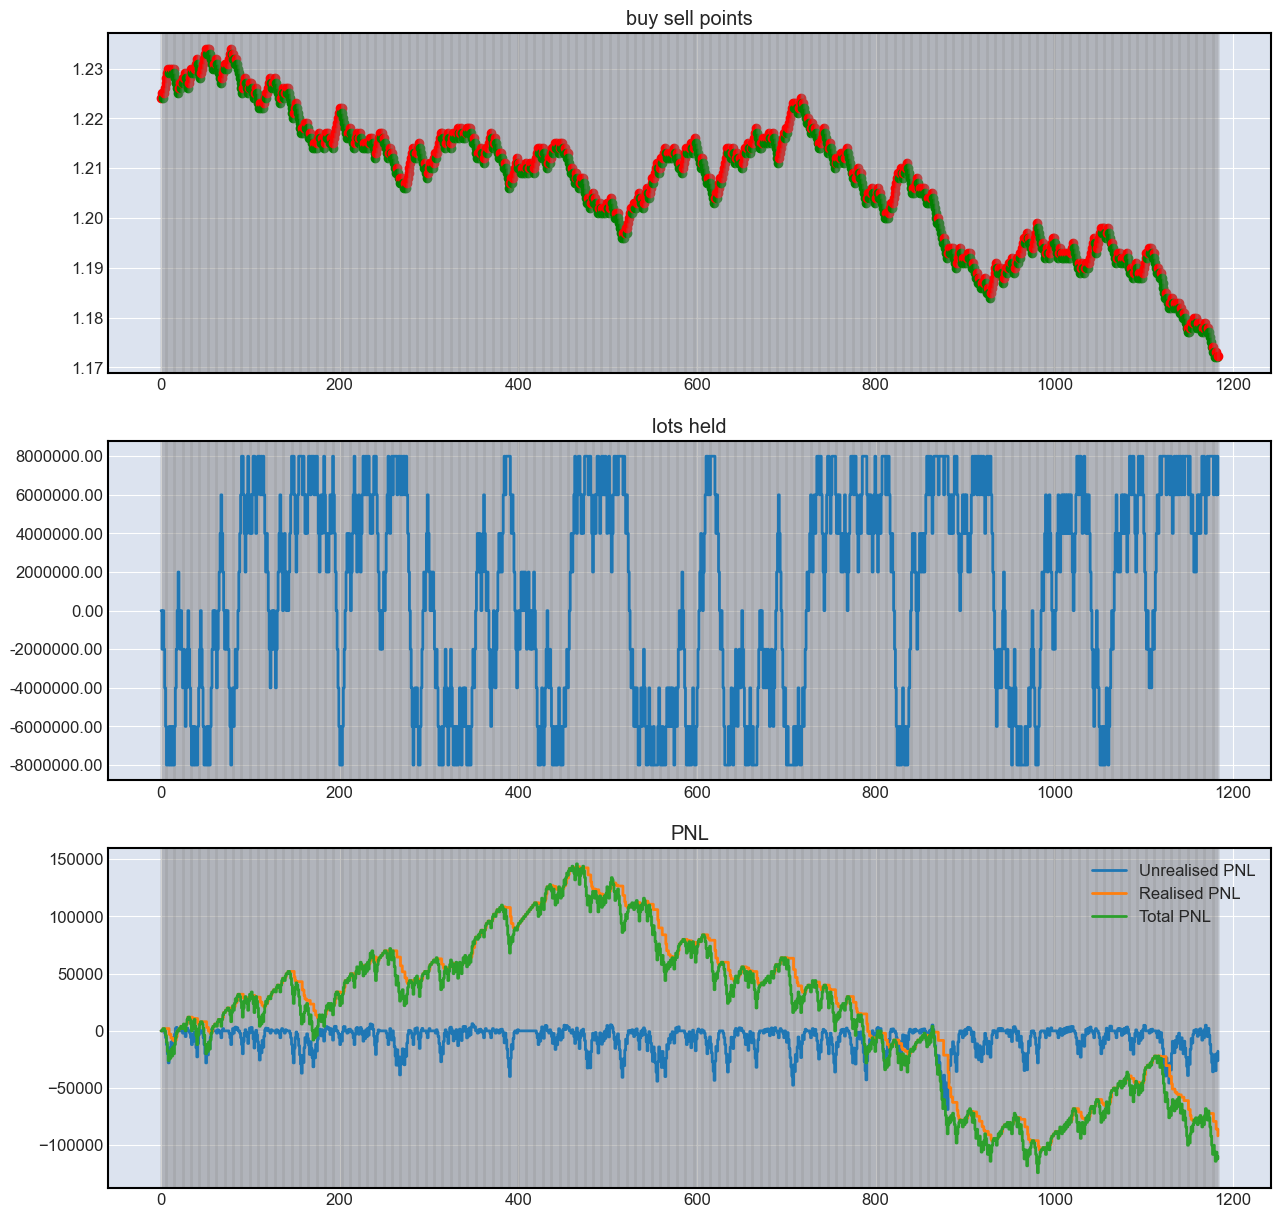

max_loss = -124000.0
min_U_PNL = -68746.582
max_position = 9880000.0
final_realised_PNL = -91803.5715
final_total_PNL = -109600.0


In [ ]:
PNL,R_PNL,U_PNL,N,P,trades= run_strategy_eval(tick_data,grid_sizing=0.001,lot_sizing=2000000,trade_plot=True,multiplier=1,lookback = 9)
print('max_loss = {}'.format(np.min(PNL)))
print('min_U_PNL = {}'.format(np.min(U_PNL)))
print('max_position = {}'.format(max(np.max(P),-np.min(P))))
print('final_realised_PNL = {}'.format(R_PNL[-1]))
print('final_total_PNL = {}'.format(PNL[-1]))

#### influence of multiplier on strategy

ladderize time:  0.017004728317260742
indicator prep time:  0.0006031990051269531
position sizing time:  0.0003349781036376953
PNL calculation time:  0.03704404830932617


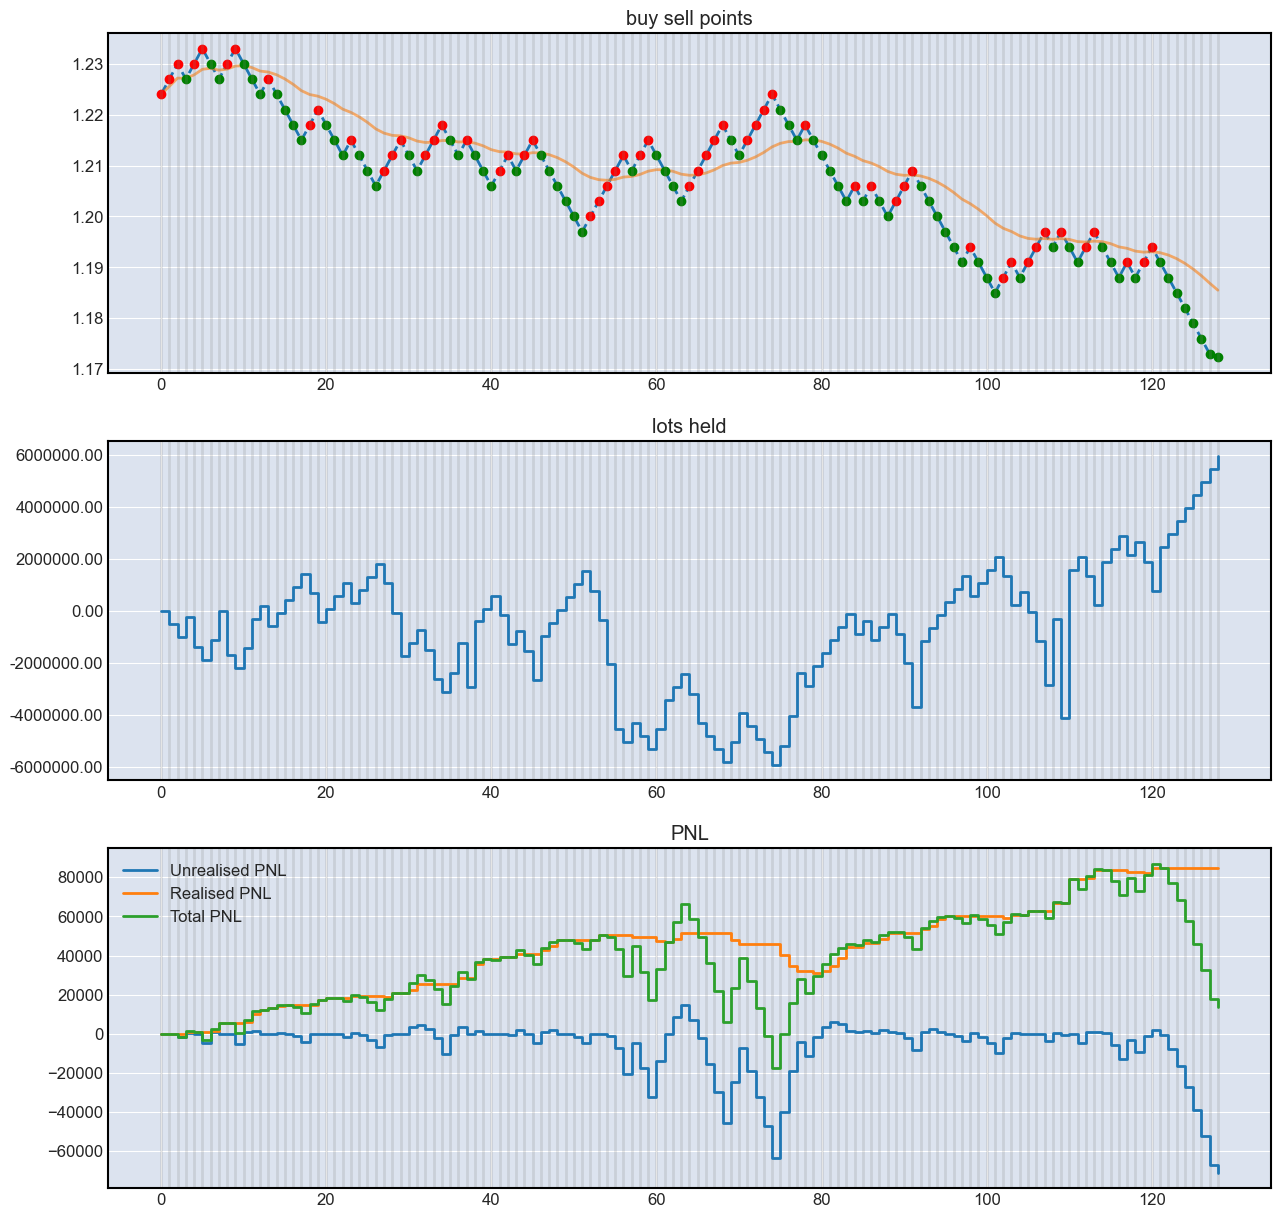

max_loss = -17718.75
min_U_PNL = -71056.7853
max_position = 7249781.25
final_realised_PNL = 84976.3276
final_total_PNL = 13919.5421


In [ ]:
PNL,R_PNL,U_PNL,N,P,trades= run_strategy_eval(tick_data,grid_sizing=0.003,lot_sizing=500000,trade_plot=True,multiplier=1.5,lookback = 20)
print('max_loss = {}'.format(np.min(PNL)))
print('min_U_PNL = {}'.format(np.min(U_PNL)))
print('max_position = {}'.format(max(np.max(P),-np.min(P))))
print('final_realised_PNL = {}'.format(R_PNL[-1]))
print('final_total_PNL = {}'.format(PNL[-1]))

#### Effect of lookback on multiplier strategy

ladderize time:  0.01409912109375
indicator prep time:  0.0005857944488525391
position sizing time:  0.0003380775451660156
PNL calculation time:  0.0337519645690918


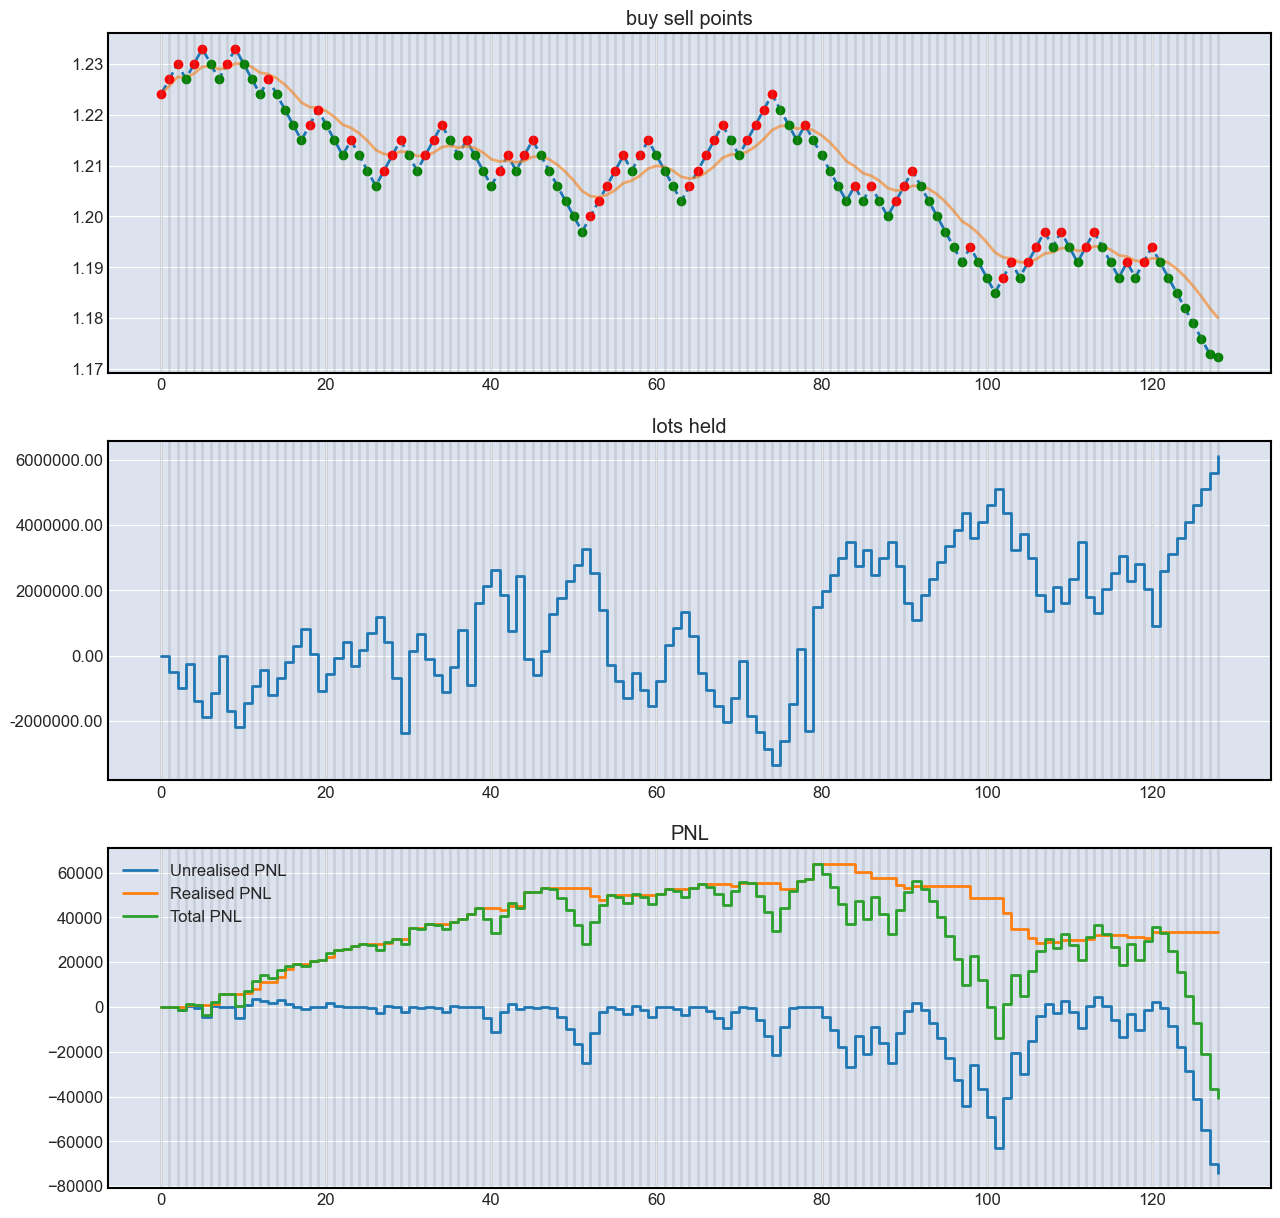

max_loss = -40395.3125
min_U_PNL = -73937.8382
max_position = 7202415.625
final_realised_PNL = 33542.5258
final_total_PNL = -40395.3125


In [ ]:
PNL,R_PNL,U_PNL,N,P,trades= run_strategy_eval(tick_data,grid_sizing=0.003,lot_sizing=500000,trade_plot=True,multiplier=1.5,lookback = 9)
print('max_loss = {}'.format(np.min(PNL)))
print('min_U_PNL = {}'.format(np.min(U_PNL)))
print('max_position = {}'.format(max(np.max(P),-np.min(P))))
print('final_realised_PNL = {}'.format(R_PNL[-1]))
print('final_total_PNL = {}'.format(PNL[-1]))

### trade with indicator

#### effect of indicator_type 

ladderize time:  0.015060901641845703
indicator prep time:  0.0007100105285644531
position sizing time:  0.000247955322265625
PNL calculation time:  0.03490304946899414


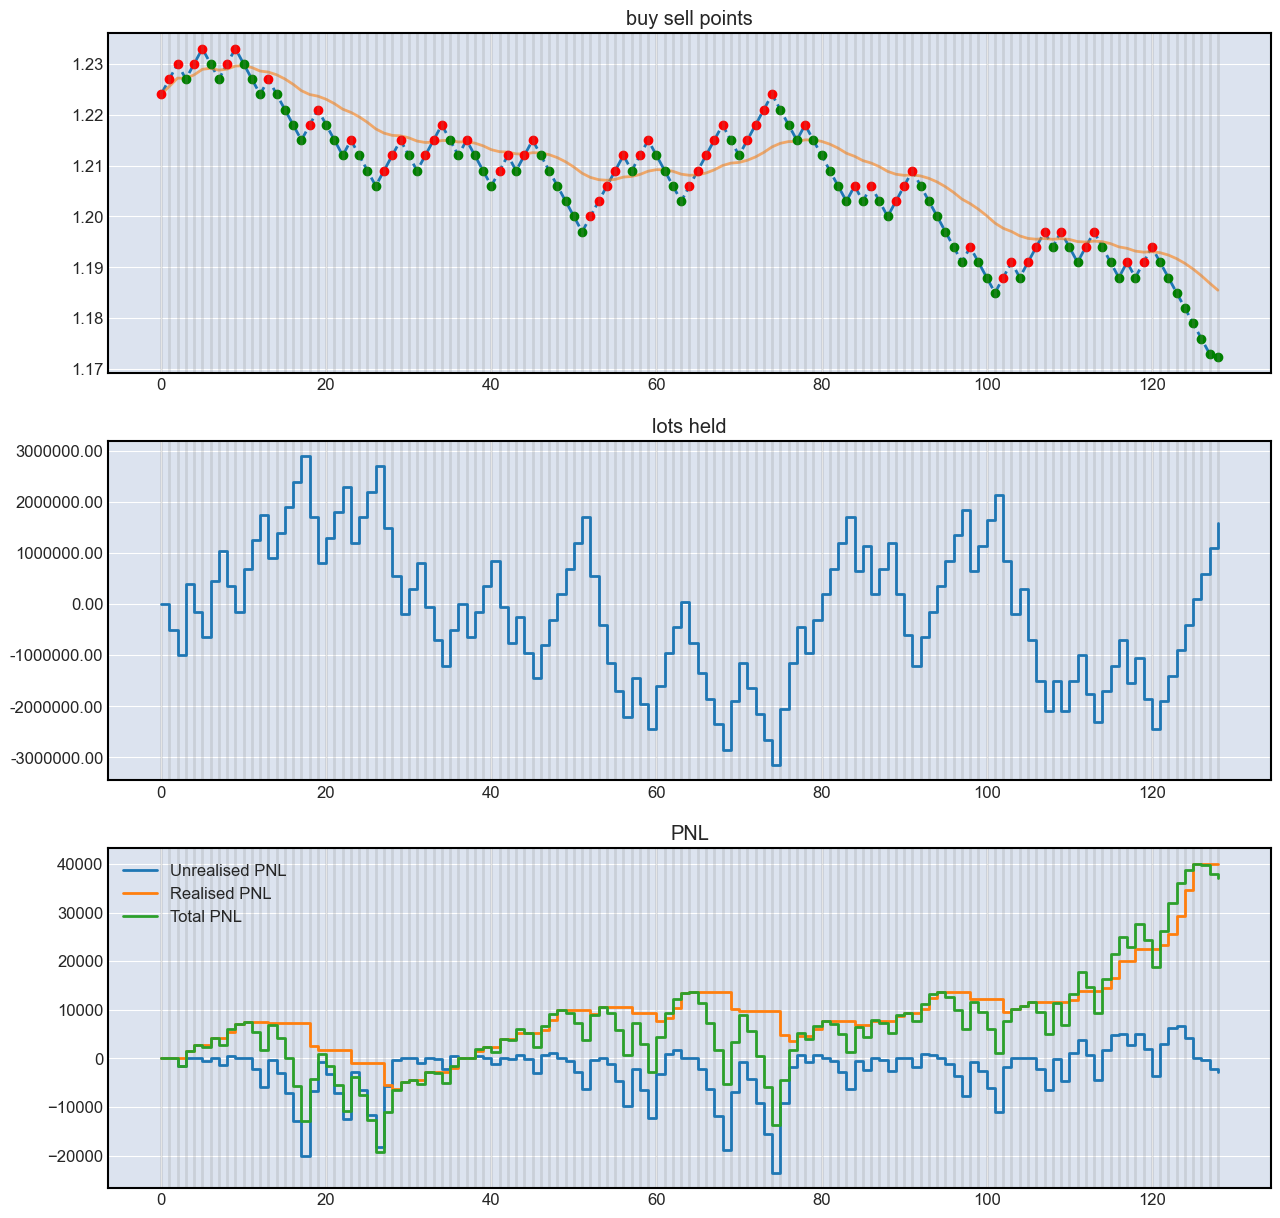

max_loss = -19200.0
min_U_PNL = -23526.3158
max_position = 3841800.0
final_realised_PNL = 40050.0001
final_total_PNL = 37180.0


In [ ]:
PNL,R_PNL,U_PNL,N,P,trades= run_strategy_eval(tick_data,grid_sizing=0.003,lot_sizing=500000,trade_plot=True,lookback = 20,indicator_type='v',indicator_scale=4)
print('max_loss = {}'.format(np.min(PNL)))
print('min_U_PNL = {}'.format(np.min(U_PNL)))
print('max_position = {}'.format(max(np.max(P),-np.min(P))))
print('final_realised_PNL = {}'.format(R_PNL[-1]))
print('final_total_PNL = {}'.format(PNL[-1]))

position limit breached at 127,
position rest to P[t-1] = 9727350.0
position limit breached at 128,
position rest to P[t-1] = 9727350.0
ladderize time:  0.017117977142333984
indicator prep time:  0.0007948875427246094
position sizing time:  0.000247955322265625
PNL calculation time:  0.03621816635131836


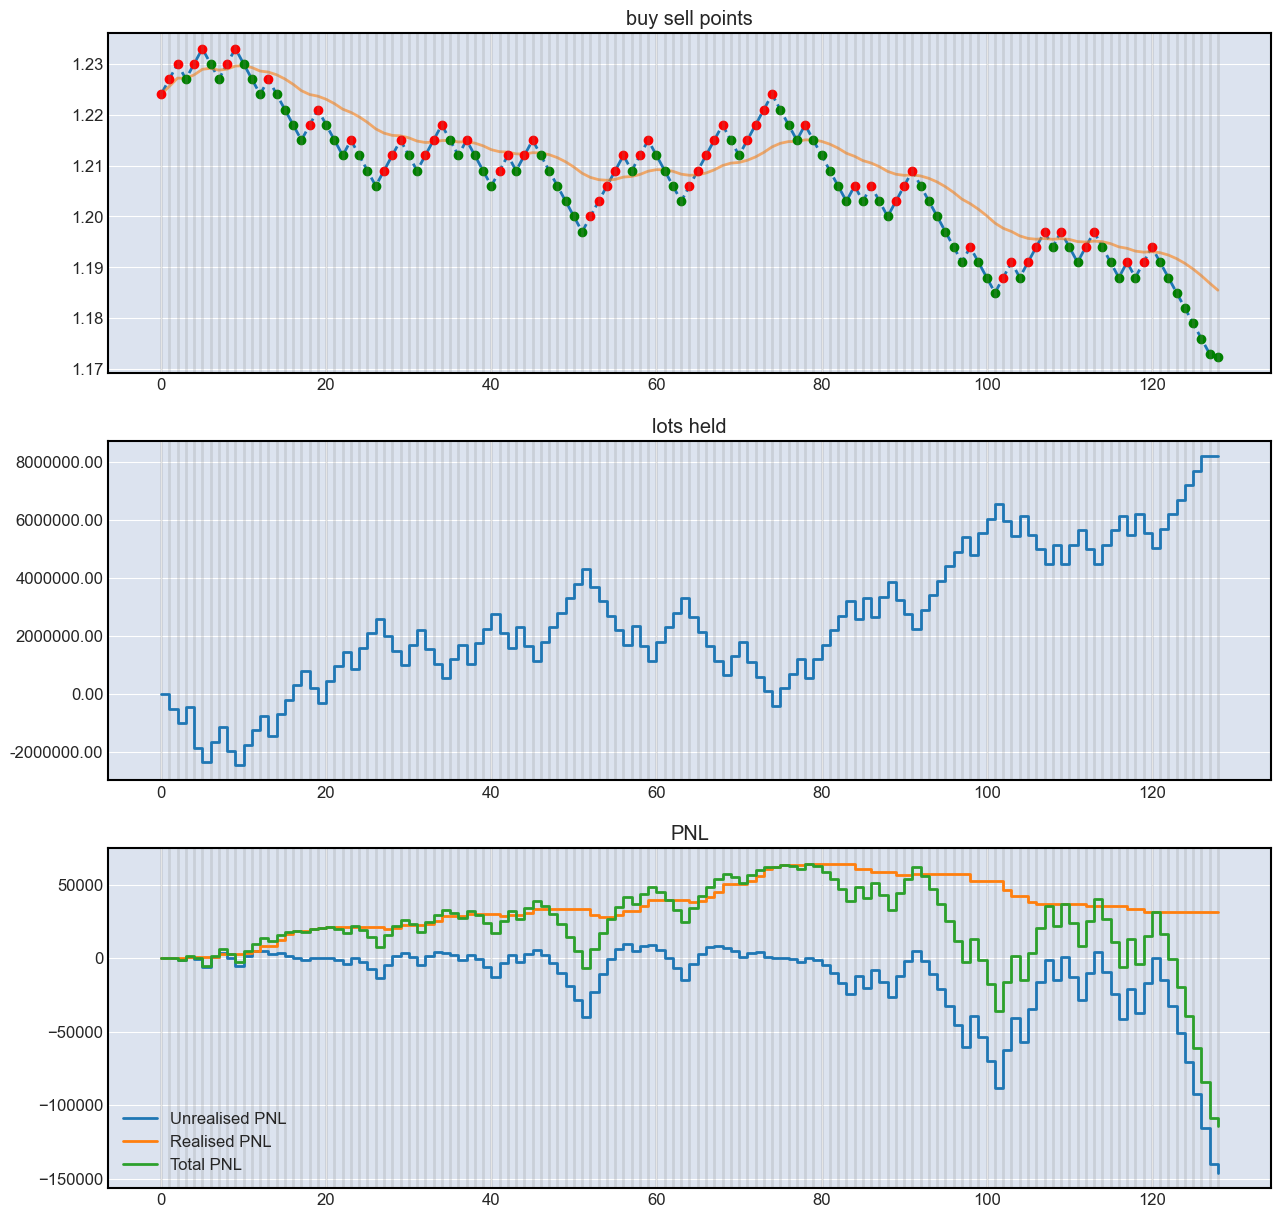

max_loss = -114490.0
min_U_PNL = -145943.5138
max_position = 9727350.0
final_realised_PNL = 31453.5141
final_total_PNL = -114490.0


In [ ]:
PNL,R_PNL,U_PNL,N,P,trades= run_strategy_eval(tick_data,grid_sizing=0.003,lot_sizing=500000,trade_plot=True,lookback = 20,indicator_type='a',indicator_scale=4)
print('max_loss = {}'.format(np.min(PNL)))
print('min_U_PNL = {}'.format(np.min(U_PNL)))
print('max_position = {}'.format(max(np.max(P),-np.min(P))))
print('final_realised_PNL = {}'.format(R_PNL[-1]))
print('final_total_PNL = {}'.format(PNL[-1]))

#### effect of indicator lookback

ladderize time:  0.015085220336914062
indicator prep time:  0.0007538795471191406
position sizing time:  0.0002579689025878906
PNL calculation time:  0.03619384765625


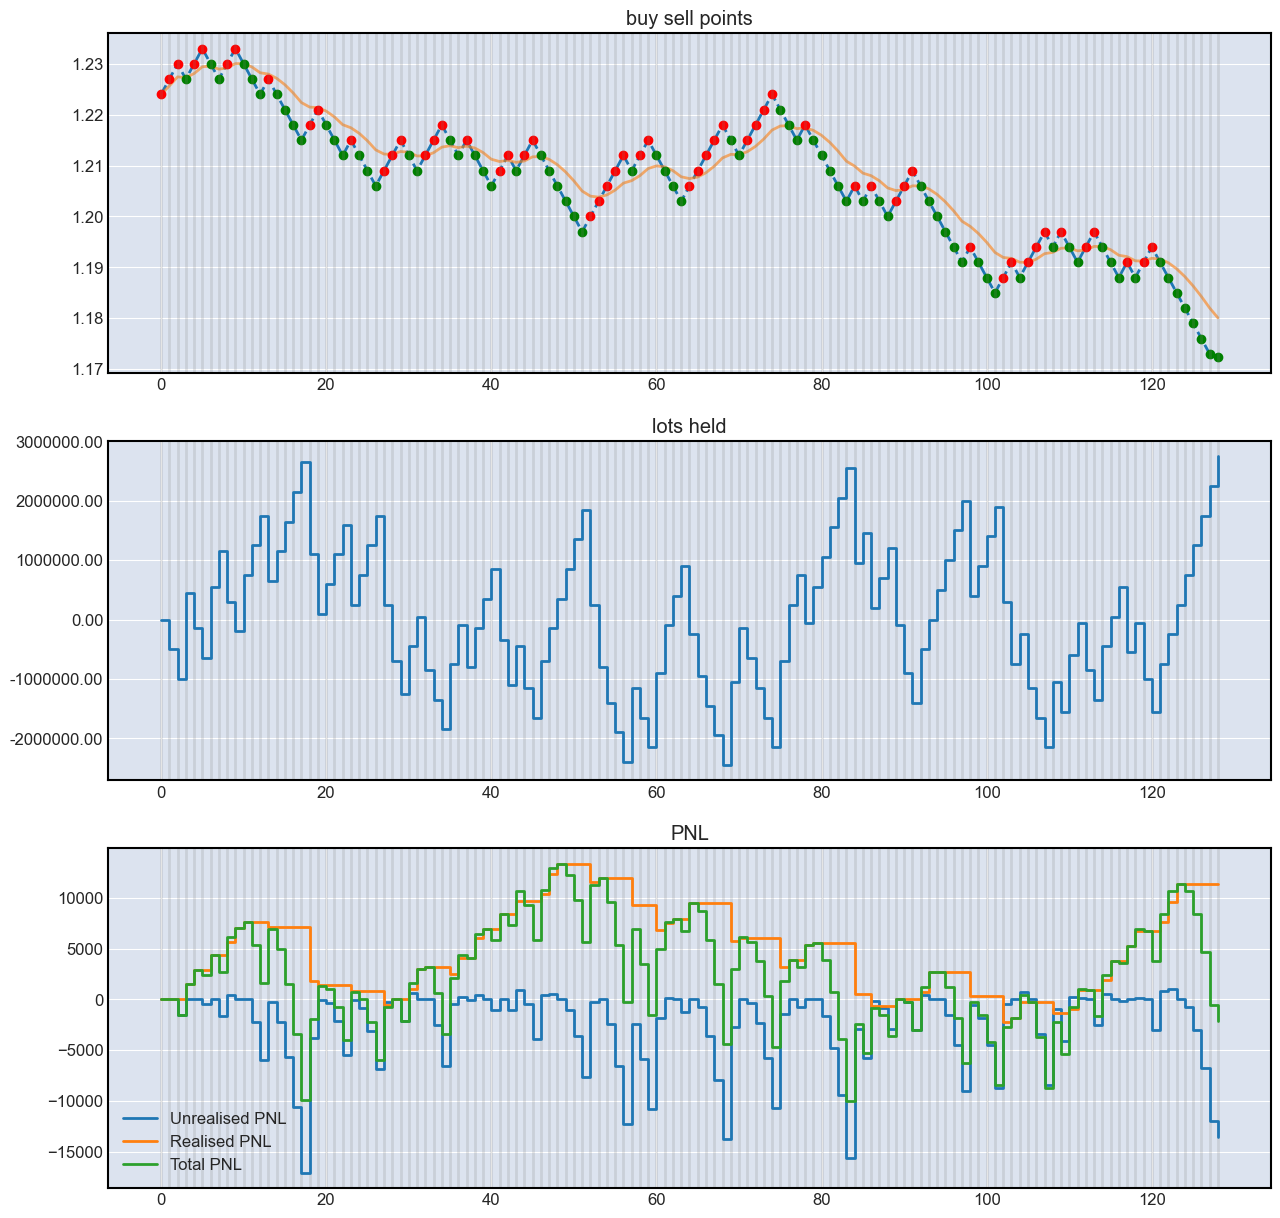

max_loss = -10050.0
min_U_PNL = -17078.5714
max_position = 3229650.0
final_realised_PNL = 11399.9999
final_total_PNL = -2175.0


In [ ]:
PNL,R_PNL,U_PNL,N,P,trades= run_strategy_eval(tick_data,grid_sizing=0.003,lot_sizing=500000,trade_plot=True,lookback = 9,indicator_type='v',indicator_scale=4)
print('max_loss = {}'.format(np.min(PNL)))
print('min_U_PNL = {}'.format(np.min(U_PNL)))
print('max_position = {}'.format(max(np.max(P),-np.min(P))))
print('final_realised_PNL = {}'.format(R_PNL[-1]))
print('final_total_PNL = {}'.format(PNL[-1]))

#### effect of scaling factor

ladderize time:  0.01636505126953125
indicator prep time:  0.0007369518280029297
position sizing time:  0.0002372264862060547
PNL calculation time:  0.03901171684265137


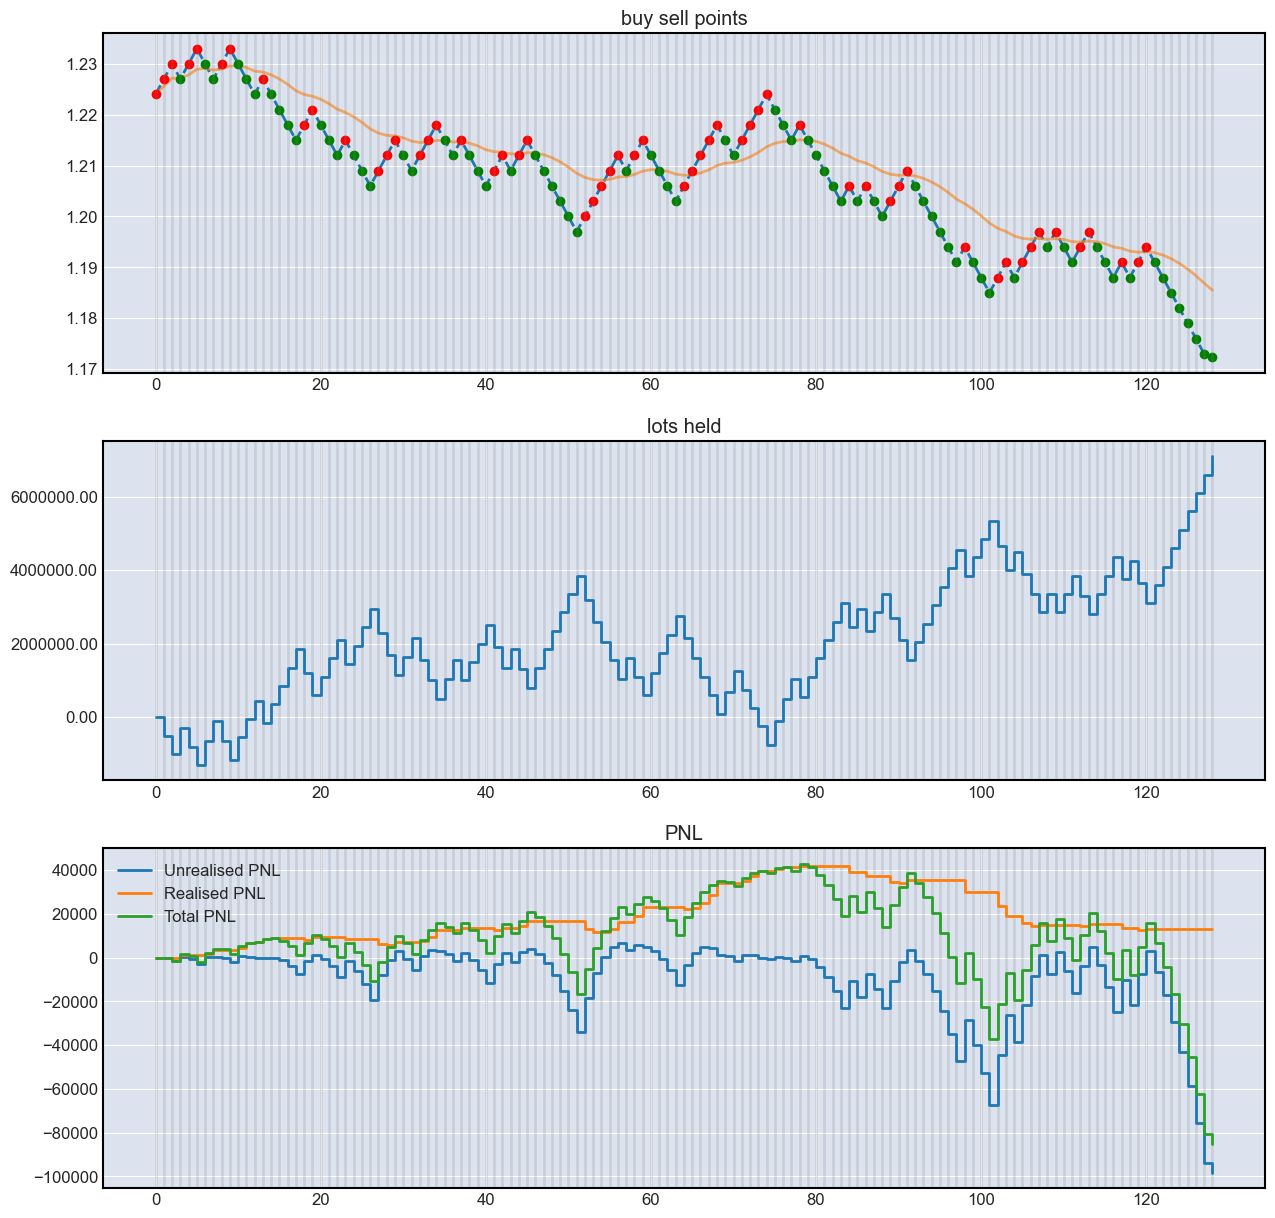

max_loss = -85320.0
min_U_PNL = -98333.5032
max_position = 8408650.0
final_realised_PNL = 13013.5031
final_total_PNL = -85320.0


In [ ]:
PNL,R_PNL,U_PNL,N,P,trades= run_strategy_eval(tick_data,grid_sizing=0.003,lot_sizing=500000,trade_plot=True,lookback = 20,indicator_type='v',indicator_scale=1)
print('max_loss = {}'.format(np.min(PNL)))
print('min_U_PNL = {}'.format(np.min(U_PNL)))
print('max_position = {}'.format(max(np.max(P),-np.min(P))))
print('final_realised_PNL = {}'.format(R_PNL[-1]))
print('final_total_PNL = {}'.format(PNL[-1]))

### time difference between jit code and non jit code for whole strategy

ladderize time:  0.014966011047363281
indicator prep time:  0.0005509853363037109
position sizing time:  0.00011610984802246094
PNL calculation time:  0.013185977935791016


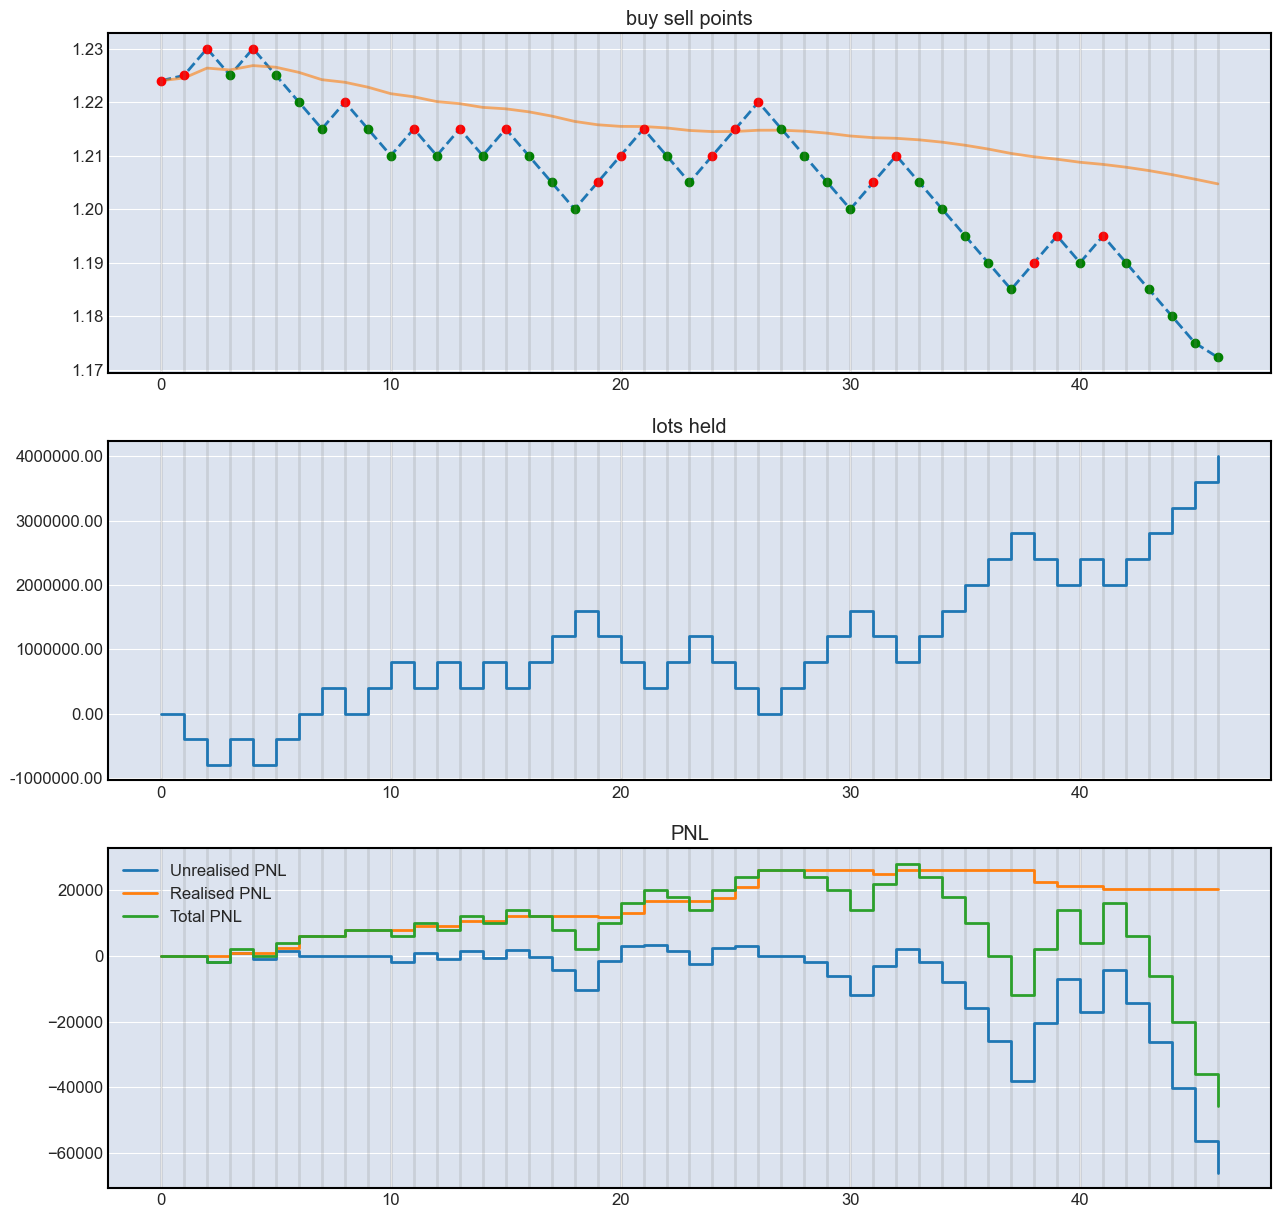

(array([     0.,      0.,  -2000.,   2000.,      0.,   4000.,   6000.,
         6000.,   8000.,   8000.,   6000.,  10000.,   8000.,  12000.,
        10000.,  14000.,  12000.,   8000.,   2000.,  10000.,  16000.,
        20000.,  18000.,  14000.,  20000.,  24000.,  26000.,  26000.,
        24000.,  20000.,  14000.,  22000.,  28000.,  24000.,  18000.,
        10000.,     -0., -12000.,   2000.,  14000.,   4000.,  16000.,
         6000.,  -6000., -20000., -36000., -45720.]), array([    0.    ,     0.    ,     0.    ,  1000.    ,  1000.    ,
        2500.    ,  6000.    ,  6000.    ,  8000.    ,  8000.    ,
        8000.    ,  9000.    ,  9000.    , 10500.    , 10500.    ,
       12250.    , 12250.    , 12250.    , 12250.    , 11687.5   ,
       13125.    , 16562.5   , 16562.5   , 16562.5   , 17708.3333,
       20854.1666, 25999.9999, 25999.9999, 25999.9999, 25999.9999,
       25999.9999, 24999.9999, 25999.9999, 25999.9999, 25999.9999,
       25999.9999, 25999.9999, 25999.9999, 22571.4285, 2

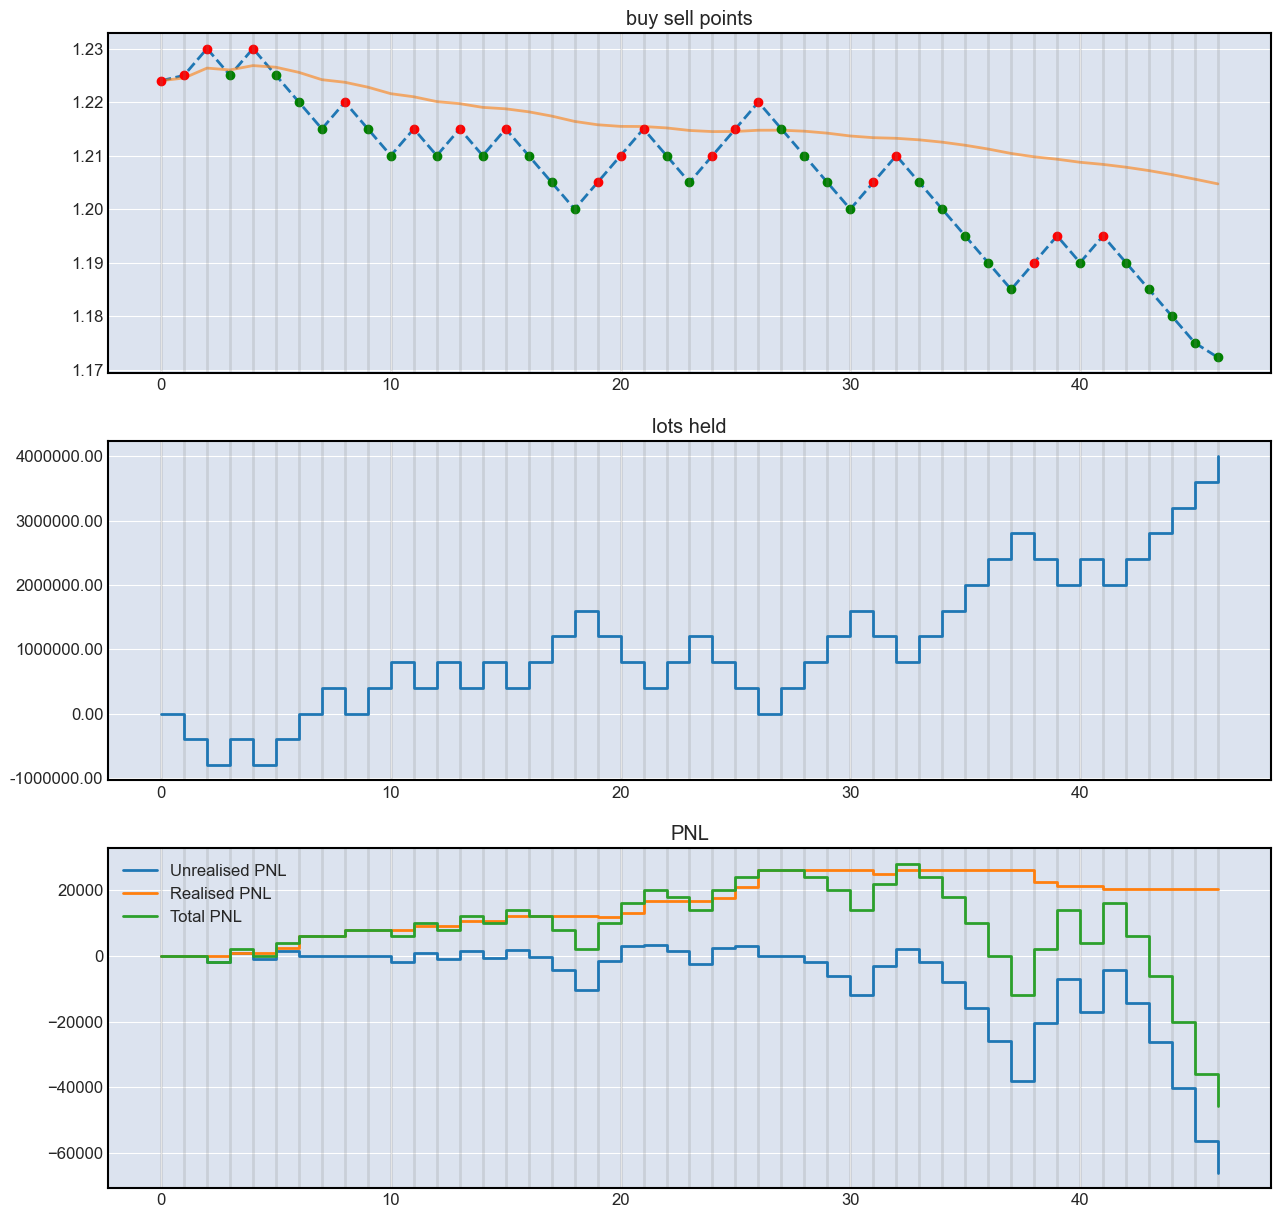

(array([     0.,      0.,  -2000.,   2000.,      0.,   4000.,   6000.,
         6000.,   8000.,   8000.,   6000.,  10000.,   8000.,  12000.,
        10000.,  14000.,  12000.,   8000.,   2000.,  10000.,  16000.,
        20000.,  18000.,  14000.,  20000.,  24000.,  26000.,  26000.,
        24000.,  20000.,  14000.,  22000.,  28000.,  24000.,  18000.,
        10000.,     -0., -12000.,   2000.,  14000.,   4000.,  16000.,
         6000.,  -6000., -20000., -36000., -45720.]), array([    0.    ,     0.    ,     0.    ,  1000.    ,  1000.    ,
        2500.    ,  6000.    ,  6000.    ,  8000.    ,  8000.    ,
        8000.    ,  9000.    ,  9000.    , 10500.    , 10500.    ,
       12250.    , 12250.    , 12250.    , 12250.    , 11687.5   ,
       13125.    , 16562.5   , 16562.5   , 16562.5   , 17708.3333,
       20854.1666, 25999.9999, 25999.9999, 25999.9999, 25999.9999,
       25999.9999, 24999.9999, 25999.9999, 25999.9999, 25999.9999,
       25999.9999, 25999.9999, 25999.9999, 22571.4285, 2

In [ ]:
#print(run_strategy_optimised(tick_data,grid_sizing=0.005,lot_sizing=400000))
time1 = time.time()
print(run_strategy_eval(tick_data,grid_sizing=0.005,lot_sizing=400000,trade_plot=True,ladder_function=ladderize_absolute_optimised))
time2 = time.time()
print(run_strategy_eval(tick_data,grid_sizing=0.005,lot_sizing=400000,trade_plot=True,ladder_function=ladderize_absolute))
time3 = time.time()
print('time for optimised: ',time2-time1)
print('time for non optimised: ',time3-time2)